# Predict RUL with NASA Turbofan Data

Useful documents.
* [How to Implement Machine Learning For Predictive Maintenance](https://towardsdatascience.com/how-to-implement-machine-learning-for-predictive-maintenance-4633cdbe4860)
* [Predictive Maintenance ML (IIoT)](https://www.kaggle.com/billstuart/predictive-maintenance-ml-iiot)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv('../input/prehackathonsup/train_data/train_data.csv')

# "engine_no" and "time_in_cycled" are not required in prediction.
metacol = ['engine_no', 'time_in_cycles']

# ******************* Check Null data *********************** #
null_rate = (dataset.isnull().sum()/dataset.shape[0]) * 100
print(null_rate)

null_col = []
threshold_ratio = 99.5 #(%)

for i, x in enumerate(null_rate.index):
    if null_rate[i] > threshold_ratio:
        null_col.append(x)

# If Null Ratio is greater than threshold_ratio, drop the column from dataset
dataset = dataset.drop(columns=null_col)
print(f'Droppd columns are: {null_col}')
# ************************************************************ #

# Get Engine No. List
engine_list = dataset['engine_no'].drop_duplicates().values

engine_no           0.0
time_in_cycles      0.0
op_setting_1        0.0
op_setting_2        0.0
op_setting_3        0.0
sensor_1            0.0
sensor_2            0.0
sensor_3            0.0
sensor_4            0.0
sensor_5            0.0
sensor_6            0.0
sensor_7            0.0
sensor_8            0.0
sensor_9            0.0
sensor_10           0.0
sensor_11           0.0
sensor_12           0.0
sensor_13           0.0
sensor_14           0.0
sensor_15           0.0
sensor_16           0.0
sensor_17           0.0
sensor_18           0.0
sensor_19           0.0
sensor_20           0.0
sensor_21           0.0
sensor_22         100.0
sensor_23         100.0
sensor_24         100.0
sensor_25         100.0
sensor_26         100.0
sensor_27         100.0
RUL                 0.0
dtype: float64
Droppd columns are: ['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27']


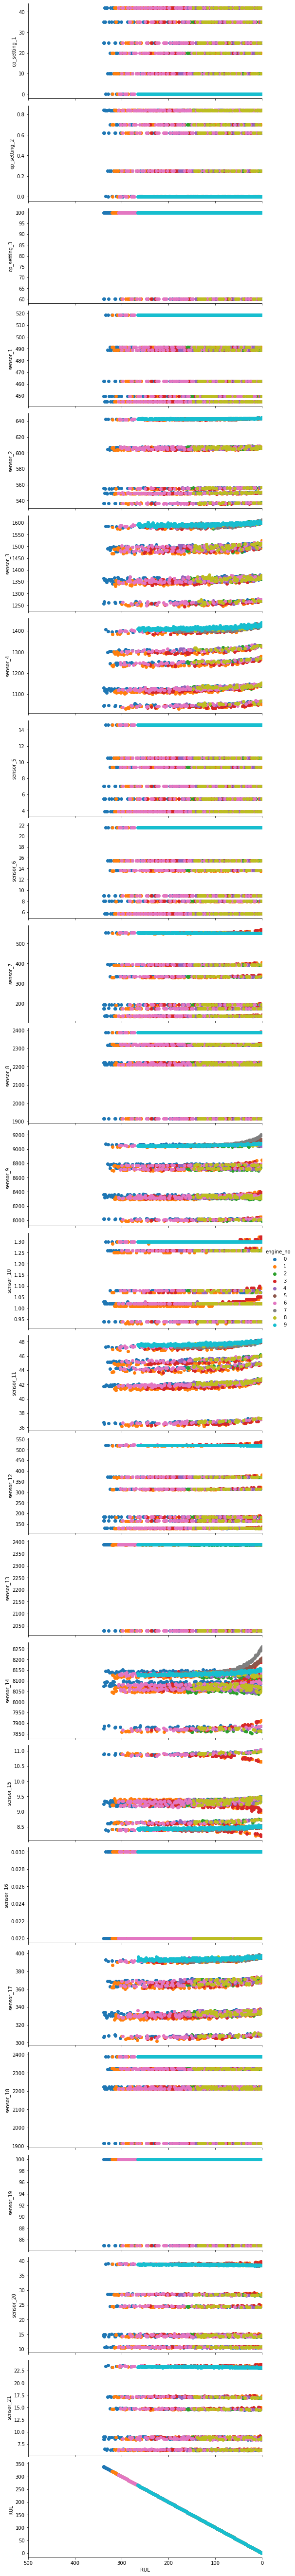

In [2]:
# use seaborn to visualize trend between features and target (RUL)
explore = sns.PairGrid(data=dataset.query('engine_no < 10') ,
                 x_vars=['RUL'],
                 y_vars=dataset.drop(columns=metacol).columns,
                 hue="engine_no", height=3, aspect=2.5)
explore = explore.map(plt.scatter)
explore = explore.set(xlim=(500,0))
explore = explore.add_legend()

## Data Visualization

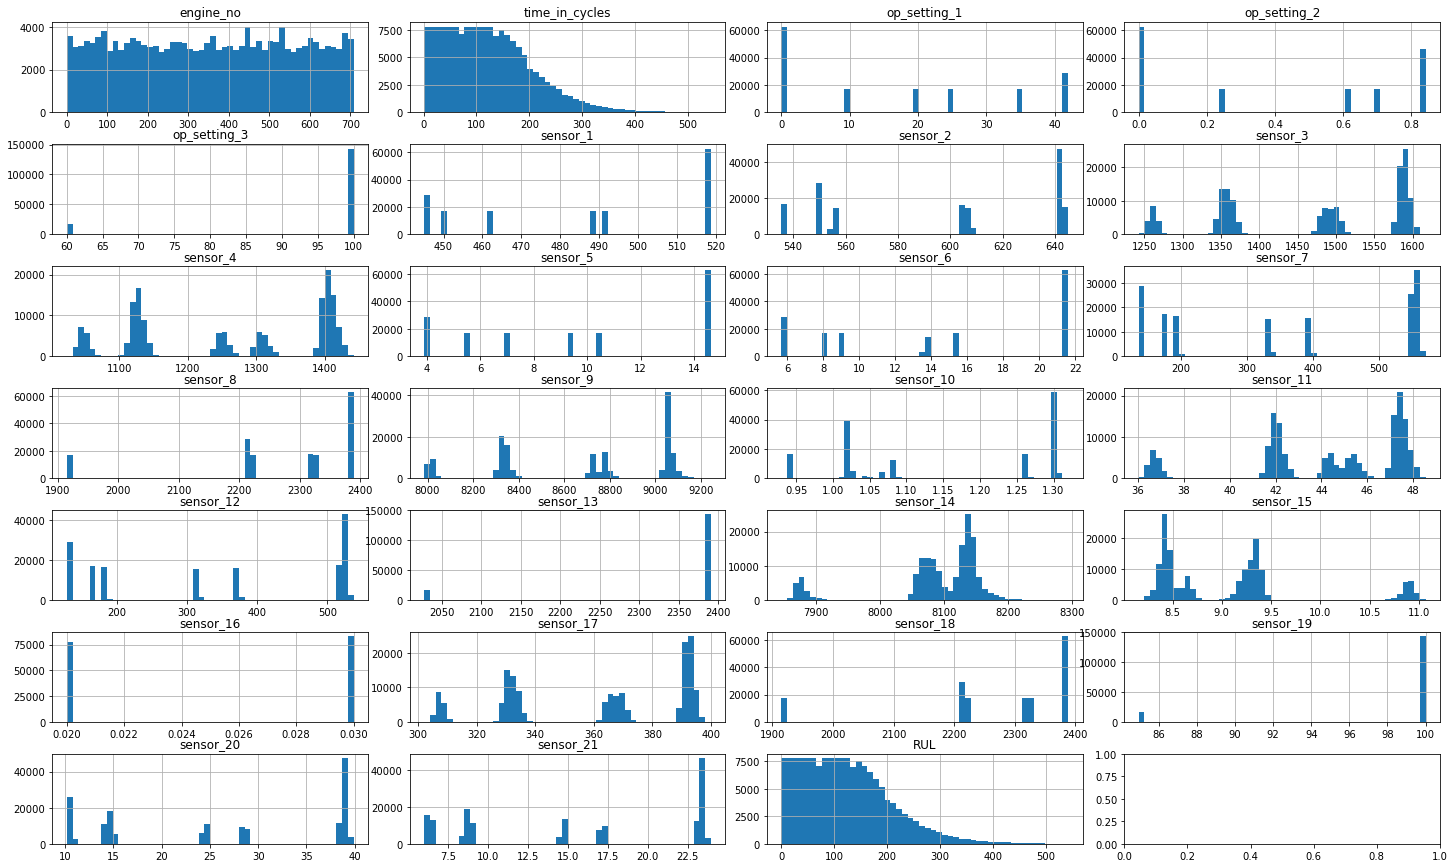

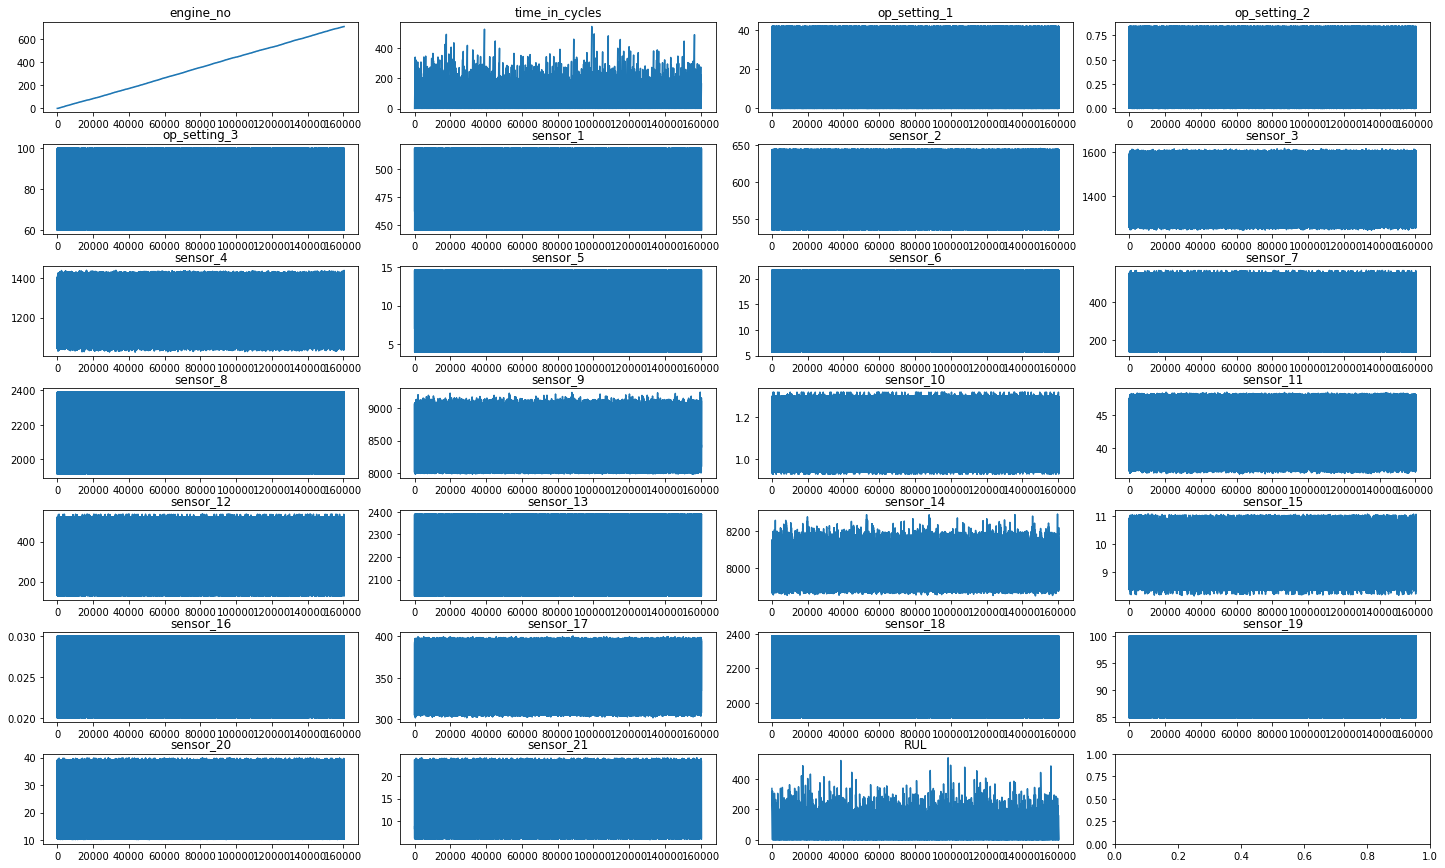

In [3]:
### Draw Histogram with all columns in dataset ###
#************************************************#
def visualize_hist(dataset):
    fig, ax = plt.subplots(ncols=4, nrows=7, figsize=(20,12))
    plt.tight_layout()
    for i, x in enumerate(dataset):
        row = int(i//4)
        col = int(i%4)
        dataset[x].hist(bins=50, ax=ax[row, col])
        ax[row, col].set_title(x)
#************************************************#


### Draw Plot with three "plot_list" columns ###
#**********************************************#
def visualize_plot(dataset):
    fig, ax = plt.subplots(ncols=4, nrows=7, figsize=(20,12))
    plt.tight_layout()
    for i, x in enumerate(dataset):
        row = int(i//4)
        col = int(i%4)
        dataset[x].plot(ax=ax[row, col])
        ax[row, col].set_title(x)
#**********************************************#


visualize_hist(dataset)

# Is there a large outlier??
visualize_plot(dataset)

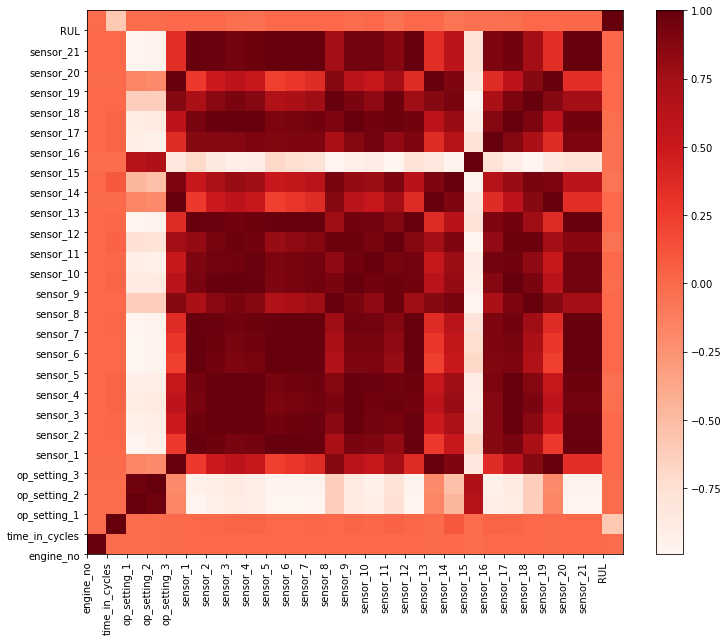

In [4]:
# Check correlation features vs RUL

corr = dataset.corr()
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.pcolor(corr, cmap=plt.cm.Reds, vmax=1.0)
ax.set_xticks(np.arange(corr.shape[0]))
ax.set_yticks(np.arange(corr.shape[1]))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
fig.colorbar(heatmap, ax=ax)

In [5]:
# Assign Features/Target variable

X = dataset.drop(columns=metacol).iloc[:,:-1]
y = dataset['RUL'].values

In [6]:
# See which features are the most important

from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
reg = RandomForestRegressor(n_estimators = 200, max_depth = 15)
reg.fit(X, y)
y_pred = reg.predict(X)
print("complete")

importances = reg.feature_importances_
columns=['col', 'val']
pd_importances = pd.DataFrame(columns=columns)
for i, x in enumerate(X.columns):
    pd_importances.loc[i] = [x, importances[i]]

# Get the most important columns in top10    
important_col = pd_importances.sort_values(by='val', ascending=False).reset_index()
print(important_col)

complete
    index           col       val
0      15     sensor_13  0.333668
1      13     sensor_11  0.204396
2      17     sensor_15  0.128145
3      11      sensor_9  0.075088
4       6      sensor_4  0.051524
5       8      sensor_6  0.051240
6      16     sensor_14  0.030504
7      14     sensor_12  0.024582
8       9      sensor_7  0.021669
9      10      sensor_8  0.016367
10      4      sensor_2  0.012490
11      5      sensor_3  0.012323
12     23     sensor_21  0.011158
13     22     sensor_20  0.008559
14      0  op_setting_1  0.008079
15      1  op_setting_2  0.005006
16     19     sensor_17  0.004321
17     12     sensor_10  0.000617
18     18     sensor_16  0.000254
19      7      sensor_5  0.000003
20     20     sensor_18  0.000003
21      3      sensor_1  0.000003
22     21     sensor_19  0.000000
23      2  op_setting_3  0.000000


In [7]:
# Get the most important columns in top18 
important_col = important_col.loc[:19, 'col']
print(important_col)

0        sensor_13
1        sensor_11
2        sensor_15
3         sensor_9
4         sensor_4
5         sensor_6
6        sensor_14
7        sensor_12
8         sensor_7
9         sensor_8
10        sensor_2
11        sensor_3
12       sensor_21
13       sensor_20
14    op_setting_1
15    op_setting_2
16       sensor_17
17       sensor_10
18       sensor_16
19        sensor_5
Name: col, dtype: object


In [8]:
# Search the best hyper-parameter using Optuna integrated LightGBM

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as lgb

params = {
    'objective': 'mean_squared_error',
    'metric': 'rmse'
}

# Data Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(dataset.loc[:,important_col].values)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

trains = lgb.Dataset(X_tr, y_tr)
tests = lgb.Dataset(X_te, y_te)

model = lgb.train(params, trains, valid_sets=tests, verbose_eval=False)
print(f'best params = {model.params}')
print(f'best score = {model.best_score}')
best_params = model.params

[I 2021-02-15 06:41:42,500] A new study created in memory with name: no-name-bf2ce1ab-d944-4e74-900c-7d074b85f58e
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


feature_fraction, val_score: 50.178749:  14%|#4        | 1/7 [00:09<00:57,  9.51s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


feature_fraction, val_score: 49.943072:  29%|##8       | 2/7 [00:15<00:37,  7.40s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


feature_fraction, val_score: 49.943072:  43%|####2     | 3/7 [00:23<00:30,  7.62s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


feature_fraction, val_score: 49.943072:  57%|#####7    | 4/7 [00:28<00:20,  6.74s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


feature_fraction, val_score: 49.918083:  71%|#######1  | 5/7 [00:36<00:13,  6.98s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


feature_fraction, val_score: 49.918083:  86%|########5 | 6/7 [00:45<00:07,  7.85s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.918083:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.918083:   5%|5         | 1/20 [00:06<01:57,  6.21s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.918083:  10%|#         | 2/20 [00:20<03:12, 10.70s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.918083:  15%|#5        | 3/20 [00:28<02:41,  9.53s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.918083:  20%|##        | 4/20 [00:42<03:04, 11.55s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.918083:  25%|##5       | 5/20 [00:57<03:11, 12.78s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.918083:  30%|###       | 6/20 [01:13<03:11, 13.67s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.918083:  35%|###5      | 7/20 [01:30<03:12, 14.82s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.918083:  40%|####      | 8/20 [01:41<02:42, 13.53s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.856673:  45%|####5     | 9/20 [01:45<01:56, 10.60s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.856673:  50%|#####     | 10/20 [01:54<01:41, 10.19s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.856673:  55%|#####5    | 11/20 [02:01<01:23,  9.28s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.856673:  60%|######    | 12/20 [02:06<01:03,  8.00s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.856673:  65%|######5   | 13/20 [02:13<00:53,  7.67s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.856673:  70%|#######   | 14/20 [02:21<00:45,  7.60s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.856673:  75%|#######5  | 15/20 [02:29<00:39,  7.86s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.856673:  80%|########  | 16/20 [02:35<00:29,  7.30s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.856673:  85%|########5 | 17/20 [02:39<00:18,  6.20s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.856673:  90%|######### | 18/20 [02:49<00:14,  7.28s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


num_leaves, val_score: 49.828861:  95%|#########5| 19/20 [02:53<00:06,  6.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


bagging, val_score: 49.828861:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


bagging, val_score: 49.828861:  10%|#         | 1/10 [00:09<01:28,  9.78s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


bagging, val_score: 49.828861:  20%|##        | 2/10 [00:18<01:14,  9.30s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


bagging, val_score: 49.828861:  30%|###       | 3/10 [00:27<01:03,  9.00s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


bagging, val_score: 49.828861:  40%|####      | 4/10 [00:35<00:52,  8.80s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


bagging, val_score: 49.828861:  50%|#####     | 5/10 [00:44<00:42,  8.57s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


bagging, val_score: 49.828861:  60%|######    | 6/10 [00:52<00:33,  8.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


bagging, val_score: 49.828861:  70%|#######   | 7/10 [01:01<00:26,  8.80s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


bagging, val_score: 49.828861:  80%|########  | 8/10 [01:10<00:17,  8.85s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


bagging, val_score: 49.828861:  90%|######### | 9/10 [01:19<00:08,  8.84s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


feature_fraction_stage2, val_score: 49.828861:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


feature_fraction_stage2, val_score: 49.828861:  33%|###3      | 1/3 [00:06<00:12,  6.16s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


feature_fraction_stage2, val_score: 49.828861:  67%|######6   | 2/3 [00:11<00:05,  5.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.828861:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.828861:   5%|5         | 1/20 [00:07<02:18,  7.31s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.828861:  10%|#         | 2/20 [00:13<02:00,  6.69s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.828861:  15%|#5        | 3/20 [00:22<02:08,  7.55s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.828861:  20%|##        | 4/20 [00:29<01:58,  7.43s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.828860:  25%|##5       | 5/20 [00:33<01:36,  6.41s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.828860:  30%|###       | 6/20 [00:41<01:33,  6.68s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.828860:  35%|###5      | 7/20 [00:47<01:25,  6.54s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.828860:  40%|####      | 8/20 [00:55<01:24,  7.01s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.828860:  45%|####5     | 9/20 [01:01<01:12,  6.60s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.828860:  50%|#####     | 10/20 [01:05<00:59,  5.99s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.819750:  55%|#####5    | 11/20 [01:13<00:57,  6.36s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.819750:  60%|######    | 12/20 [01:19<00:50,  6.33s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.819750:  65%|######5   | 13/20 [01:27<00:48,  6.92s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.807675:  70%|#######   | 14/20 [01:34<00:42,  7.03s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.807675:  75%|#######5  | 15/20 [01:41<00:33,  6.79s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.807675:  80%|########  | 16/20 [01:48<00:28,  7.05s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.804185:  85%|########5 | 17/20 [01:56<00:21,  7.14s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.804185:  90%|######### | 18/20 [02:03<00:14,  7.13s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


regularization_factors, val_score: 49.767768:  95%|#########5| 19/20 [02:08<00:06,  6.70s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


min_data_in_leaf, val_score: 49.767768:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


min_data_in_leaf, val_score: 49.767768:  20%|##        | 1/5 [00:07<00:30,  7.71s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


min_data_in_leaf, val_score: 49.767768:  40%|####      | 2/5 [00:12<00:18,  6.01s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


min_data_in_leaf, val_score: 49.767768:  60%|######    | 3/5 [00:20<00:13,  7.00s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


min_data_in_leaf, val_score: 49.767768:  80%|########  | 4/5 [00:26<00:06,  6.45s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 20
[LightGBM] [Info] Start training from score 122.420783


min_data_in_leaf, val_score: 49.767768: 100%|##########| 5/5 [00:32<00:00,  6.51s/it]

best params = {'objective': 'mean_squared_error', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 9.209013255699873, 'lambda_l2': 5.861166768736052, 'num_leaves': 22, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': None}
best score = defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('rmse', 49.767768049741385)])})


> best params = {'objective': 'mean_squared_error', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 9.209013255699873, 'lambda_l2': 5.861166768736052, 'num_leaves': 22, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': None}
best score = defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('rmse', 49.767768049741385)])})


In [9]:
# XGBoost Parameter tuning

import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
import optuna

# XGBoost Parameters — xgboost 1.4.0-SNAPSHOT documentation https://xgboost.readthedocs.io/en/latest/parameter.html

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'gpu_hist',
        'eta': trial.suggest_loguniform('eta', 0.1, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 0.001, 5.),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'sub_sample': trial.suggest_loguniform('sub_sample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 0.001, 0.01),
        'alpha': trial.suggest_loguniform('alpha', 0.001, 0.01),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
    }  
    
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_tr, y_tr, eval_set = [(X_te, y_te)],  early_stopping_rounds=10)
    y_pred = xgb_model.predict(X)
    
    return np.sqrt(mean_squared_error(y, y_pred))

study = optuna.create_study()
study.optimize(objective, n_trials=50, n_jobs=-1)
xgb_best = study.best_params
print(xgb_best)

[I 2021-02-15 06:50:15,312] A new study created in memory with name: no-name-79284c2e-13e9-4ec0-a37c-4b398339b924


[0]	validation_0-rmse:146.01480
[1]	validation_0-rmse:144.68961
[2]	validation_0-rmse:143.37262
[3]	validation_0-rmse:142.07065
[0]	validation_0-rmse:147.33025
[4]	validation_0-rmse:140.82239
[5]	validation_0-rmse:139.58562
[6]	validation_0-rmse:138.34376
[7]	validation_0-rmse:137.12111
[1]	validation_0-rmse:147.29050
[8]	validation_0-rmse:135.88809
[9]	validation_0-rmse:134.68945
[10]	validation_0-rmse:133.48914
[11]	validation_0-rmse:132.31119
[12]	validation_0-rmse:131.16844
[2]	validation_0-rmse:147.25092
[13]	validation_0-rmse:130.02264
[14]	validation_0-rmse:128.91090
[15]	validation_0-rmse:127.83003
[16]	validation_0-rmse:126.72757
[3]	validation_0-rmse:147.21130
[17]	validation_0-rmse:125.65253
[18]	validation_0-rmse:124.60099
[19]	validation_0-rmse:123.56017
[20]	validation_0-rmse:122.51939
[21]	validation_0-rmse:121.56401
[4]	validation_0-rmse:147.17171
[22]	validation_0-rmse:120.53830
[23]	validation_0-rmse:119.52786
[24]	validation_0-rmse:118.56843
[25]	validation_0-rmse:11

[212]	validation_0-rmse:57.60224
[39]	validation_0-rmse:145.79526
[213]	validation_0-rmse:57.55320
[214]	validation_0-rmse:57.50832
[215]	validation_0-rmse:57.45175
[216]	validation_0-rmse:57.40561
[217]	validation_0-rmse:57.35179
[218]	validation_0-rmse:57.30871
[40]	validation_0-rmse:145.75618
[219]	validation_0-rmse:57.26847
[220]	validation_0-rmse:57.22372
[221]	validation_0-rmse:57.18098
[222]	validation_0-rmse:57.13464
[223]	validation_0-rmse:57.09411
[41]	validation_0-rmse:145.71744
[224]	validation_0-rmse:57.05523
[225]	validation_0-rmse:57.01701
[226]	validation_0-rmse:56.97535
[227]	validation_0-rmse:56.94359
[42]	validation_0-rmse:145.67839
[228]	validation_0-rmse:56.90598
[229]	validation_0-rmse:56.87210
[230]	validation_0-rmse:56.82436
[231]	validation_0-rmse:56.78788
[232]	validation_0-rmse:56.75392
[43]	validation_0-rmse:145.63945
[233]	validation_0-rmse:56.71806
[234]	validation_0-rmse:56.68856
[235]	validation_0-rmse:56.65027
[236]	validation_0-rmse:56.62249
[237]	vali

[417]	validation_0-rmse:53.45631
[418]	validation_0-rmse:53.44547
[419]	validation_0-rmse:53.43467
[420]	validation_0-rmse:53.42718
[421]	validation_0-rmse:53.41951
[83]	validation_0-rmse:144.08954
[422]	validation_0-rmse:53.41209
[423]	validation_0-rmse:53.40280
[424]	validation_0-rmse:53.39424
[425]	validation_0-rmse:53.38662
[426]	validation_0-rmse:53.37941
[84]	validation_0-rmse:144.05109
[427]	validation_0-rmse:53.37103
[428]	validation_0-rmse:53.36304
[429]	validation_0-rmse:53.35621
[430]	validation_0-rmse:53.34862
[431]	validation_0-rmse:53.33969
[432]	validation_0-rmse:53.32657
[85]	validation_0-rmse:144.01268
[433]	validation_0-rmse:53.31802
[434]	validation_0-rmse:53.30823
[435]	validation_0-rmse:53.30090
[436]	validation_0-rmse:53.28842
[437]	validation_0-rmse:53.28052
[438]	validation_0-rmse:53.27414
[86]	validation_0-rmse:143.97424
[439]	validation_0-rmse:53.26185
[440]	validation_0-rmse:53.25442
[441]	validation_0-rmse:53.24689
[442]	validation_0-rmse:53.23998
[443]	vali

[I 2021-02-15 06:50:20,985] Trial 0 finished with value: 52.69184903248304 and parameters: {'eta': 0.8525112898756959, 'gamma': 0.014018280136089875, 'max_depth': 4, 'sub_sample': 0.5160249457012461, 'colsample_bytree': 0.7624432101516383, 'lambda': 0.0051791191079190325, 'alpha': 0.004426222551216616, 'learning_rate': 0.011402282512614196, 'n_estimators': 494}. Best is trial 0 with value: 52.69184903248304.


[0]	validation_0-rmse:145.60199
[1]	validation_0-rmse:143.88524
[2]	validation_0-rmse:142.18544
[3]	validation_0-rmse:140.51109
[4]	validation_0-rmse:138.90527
[5]	validation_0-rmse:137.28098
[6]	validation_0-rmse:135.70549
[7]	validation_0-rmse:134.14185
[8]	validation_0-rmse:132.59990
[9]	validation_0-rmse:131.08856
[10]	validation_0-rmse:129.60394
[11]	validation_0-rmse:128.14531
[12]	validation_0-rmse:126.71453
[13]	validation_0-rmse:125.29144
[14]	validation_0-rmse:123.92577
[15]	validation_0-rmse:122.55230
[16]	validation_0-rmse:121.22106
[17]	validation_0-rmse:119.90056
[18]	validation_0-rmse:118.61517
[19]	validation_0-rmse:117.36192
[20]	validation_0-rmse:116.10646
[21]	validation_0-rmse:114.91159
[22]	validation_0-rmse:113.70065
[23]	validation_0-rmse:112.52596
[24]	validation_0-rmse:111.39594
[25]	validation_0-rmse:110.27517
[26]	validation_0-rmse:109.14800
[27]	validation_0-rmse:108.05751
[28]	validation_0-rmse:106.99290
[29]	validation_0-rmse:105.95750
[30]	validation_0-rm

[I 2021-02-15 06:50:22,266] Trial 1 finished with value: 142.10296181584314 and parameters: {'eta': 0.1603670238665005, 'gamma': 0.5203522179557291, 'max_depth': 8, 'sub_sample': 0.839543301223951, 'colsample_bytree': 0.9952676316307996, 'lambda': 0.001339226371167038, 'alpha': 0.0011415164925695526, 'learning_rate': 0.0003143173166212993, 'n_estimators': 145}. Best is trial 0 with value: 52.69184903248304.


[225]	validation_0-rmse:55.15331
[226]	validation_0-rmse:55.12614
[227]	validation_0-rmse:55.09877
[228]	validation_0-rmse:55.06753
[229]	validation_0-rmse:55.04128
[230]	validation_0-rmse:55.01630
[231]	validation_0-rmse:54.99126
[232]	validation_0-rmse:54.96502
[233]	validation_0-rmse:54.93946
[234]	validation_0-rmse:54.91168
[235]	validation_0-rmse:54.88773
[236]	validation_0-rmse:54.86382
[237]	validation_0-rmse:54.84234
[238]	validation_0-rmse:54.81989
[239]	validation_0-rmse:54.79633
[0]	validation_0-rmse:147.15006
[240]	validation_0-rmse:54.76599
[1]	validation_0-rmse:146.93008
[2]	validation_0-rmse:146.70351
[241]	validation_0-rmse:54.74133
[242]	validation_0-rmse:54.72038
[3]	validation_0-rmse:146.47601
[243]	validation_0-rmse:54.70042
[4]	validation_0-rmse:146.25317
[244]	validation_0-rmse:54.67819
[5]	validation_0-rmse:146.03563
[6]	validation_0-rmse:145.81792
[245]	validation_0-rmse:54.65579
[7]	validation_0-rmse:145.59451
[246]	validation_0-rmse:54.63338
[8]	validation_0-r

[363]	validation_0-rmse:53.05516
[111]	validation_0-rmse:124.92396
[364]	validation_0-rmse:53.04750
[365]	validation_0-rmse:53.03831
[112]	validation_0-rmse:124.74610
[366]	validation_0-rmse:53.02757
[113]	validation_0-rmse:124.56930
[367]	validation_0-rmse:53.02047
[114]	validation_0-rmse:124.40009
[368]	validation_0-rmse:53.01134
[115]	validation_0-rmse:124.22547
[369]	validation_0-rmse:53.00293
[116]	validation_0-rmse:124.05016
[370]	validation_0-rmse:52.99575
[371]	validation_0-rmse:52.98822
[372]	validation_0-rmse:52.97956
[117]	validation_0-rmse:123.87505
[373]	validation_0-rmse:52.97239
[374]	validation_0-rmse:52.96418
[118]	validation_0-rmse:123.70508
[119]	validation_0-rmse:123.52797
[375]	validation_0-rmse:52.95720
[120]	validation_0-rmse:123.36093
[376]	validation_0-rmse:52.94813
[121]	validation_0-rmse:123.18506
[377]	validation_0-rmse:52.94224
[378]	validation_0-rmse:52.93252
[122]	validation_0-rmse:123.00761
[379]	validation_0-rmse:52.92216
[123]	validation_0-rmse:122.832

[215]	validation_0-rmse:108.41264
[505]	validation_0-rmse:52.19229
[506]	validation_0-rmse:52.18775
[216]	validation_0-rmse:108.27698
[507]	validation_0-rmse:52.18119
[217]	validation_0-rmse:108.13163
[508]	validation_0-rmse:52.17777
[218]	validation_0-rmse:107.99279
[509]	validation_0-rmse:52.17323
[219]	validation_0-rmse:107.85772
[510]	validation_0-rmse:52.16897
[220]	validation_0-rmse:107.71690
[511]	validation_0-rmse:52.16457
[221]	validation_0-rmse:107.58247
[512]	validation_0-rmse:52.15860
[513]	validation_0-rmse:52.15484
[222]	validation_0-rmse:107.44468
[514]	validation_0-rmse:52.15145
[223]	validation_0-rmse:107.30495
[515]	validation_0-rmse:52.14731
[516]	validation_0-rmse:52.14387
[224]	validation_0-rmse:107.16576
[517]	validation_0-rmse:52.14046
[518]	validation_0-rmse:52.13726
[225]	validation_0-rmse:107.02636
[519]	validation_0-rmse:52.13312
[226]	validation_0-rmse:106.88454
[520]	validation_0-rmse:52.12815
[227]	validation_0-rmse:106.74611
[521]	validation_0-rmse:52.124

[381]	validation_0-rmse:88.95242
[382]	validation_0-rmse:88.85599
[383]	validation_0-rmse:88.75977
[384]	validation_0-rmse:88.66330
[385]	validation_0-rmse:88.57408
[386]	validation_0-rmse:88.47844
[387]	validation_0-rmse:88.38147
[388]	validation_0-rmse:88.28436
[389]	validation_0-rmse:88.18872
[390]	validation_0-rmse:88.09596
[391]	validation_0-rmse:88.00306
[392]	validation_0-rmse:87.90869
[393]	validation_0-rmse:87.81484
[394]	validation_0-rmse:87.72124
[395]	validation_0-rmse:87.63074
[396]	validation_0-rmse:87.53713
[397]	validation_0-rmse:87.44202
[398]	validation_0-rmse:87.35758
[399]	validation_0-rmse:87.26476
[400]	validation_0-rmse:87.18228
[401]	validation_0-rmse:87.09029
[402]	validation_0-rmse:86.99792
[403]	validation_0-rmse:86.90765
[404]	validation_0-rmse:86.81424
[405]	validation_0-rmse:86.72315
[406]	validation_0-rmse:86.63294
[407]	validation_0-rmse:86.54481
[408]	validation_0-rmse:86.45165
[409]	validation_0-rmse:86.36131
[410]	validation_0-rmse:86.27106
[411]	vali

[I 2021-02-15 06:50:26,886] Trial 2 finished with value: 51.58414682456107 and parameters: {'eta': 0.10776092436341078, 'gamma': 0.0050091387907913116, 'max_depth': 4, 'sub_sample': 0.6590712738893552, 'colsample_bytree': 0.888257040187644, 'lambda': 0.0015934970892915684, 'alpha': 0.009331862043510317, 'learning_rate': 0.01484086260093442, 'n_estimators': 586}. Best is trial 2 with value: 51.58414682456107.


[551]	validation_0-rmse:75.63316
[552]	validation_0-rmse:75.57033
[553]	validation_0-rmse:75.50653
[554]	validation_0-rmse:75.44392
[555]	validation_0-rmse:75.38223
[556]	validation_0-rmse:75.32014
[557]	validation_0-rmse:75.25882
[558]	validation_0-rmse:75.19618
[559]	validation_0-rmse:75.13696
[560]	validation_0-rmse:75.07433
[561]	validation_0-rmse:75.01283
[562]	validation_0-rmse:74.95432
[563]	validation_0-rmse:74.89288
[564]	validation_0-rmse:74.83143
[565]	validation_0-rmse:74.77843
[566]	validation_0-rmse:74.71745
[567]	validation_0-rmse:74.66435
[568]	validation_0-rmse:74.60343
[569]	validation_0-rmse:74.54427
[0]	validation_0-rmse:138.94803
[570]	validation_0-rmse:74.48851
[1]	validation_0-rmse:131.01274
[571]	validation_0-rmse:74.42873
[2]	validation_0-rmse:123.62638
[3]	validation_0-rmse:116.77278
[572]	validation_0-rmse:74.37126
[4]	validation_0-rmse:110.59369
[573]	validation_0-rmse:74.31570
[5]	validation_0-rmse:104.96838
[574]	validation_0-rmse:74.25595
[575]	validation

[694]	validation_0-rmse:68.29248
[695]	validation_0-rmse:68.24974
[696]	validation_0-rmse:68.20940
[697]	validation_0-rmse:68.16966
[698]	validation_0-rmse:68.12778
[699]	validation_0-rmse:68.08420
[700]	validation_0-rmse:68.04134
[701]	validation_0-rmse:68.00002
[702]	validation_0-rmse:67.95939
[703]	validation_0-rmse:67.91647
[704]	validation_0-rmse:67.87415
[705]	validation_0-rmse:67.83064
[706]	validation_0-rmse:67.78643
[707]	validation_0-rmse:67.74321
[708]	validation_0-rmse:67.70145
[709]	validation_0-rmse:67.66291
[710]	validation_0-rmse:67.62254
[711]	validation_0-rmse:67.57962
[712]	validation_0-rmse:67.53826
[713]	validation_0-rmse:67.49739
[714]	validation_0-rmse:67.45933
[715]	validation_0-rmse:67.41959
[716]	validation_0-rmse:67.37758
[717]	validation_0-rmse:67.34037
[718]	validation_0-rmse:67.29777
[719]	validation_0-rmse:67.26009
[720]	validation_0-rmse:67.21847
[721]	validation_0-rmse:67.17575
[722]	validation_0-rmse:67.13895
[723]	validation_0-rmse:67.09835


[I 2021-02-15 06:50:28,586] Trial 4 finished with value: 50.69008083703864 and parameters: {'eta': 0.9568726585607333, 'gamma': 0.18418586357888345, 'max_depth': 5, 'sub_sample': 0.671429336840469, 'colsample_bytree': 0.5813934427741996, 'lambda': 0.0012782700026400119, 'alpha': 0.004749747715302166, 'learning_rate': 0.07304567272890072, 'n_estimators': 109}. Best is trial 4 with value: 50.69008083703864.


[0]	validation_0-rmse:147.18945
[1]	validation_0-rmse:147.00647
[2]	validation_0-rmse:146.82378
[3]	validation_0-rmse:146.64188
[4]	validation_0-rmse:146.46104
[5]	validation_0-rmse:146.28149
[6]	validation_0-rmse:146.10020
[7]	validation_0-rmse:145.91887
[8]	validation_0-rmse:145.73764
[9]	validation_0-rmse:145.55811
[10]	validation_0-rmse:145.37825
[11]	validation_0-rmse:145.20145
[12]	validation_0-rmse:145.02164
[13]	validation_0-rmse:144.84244
[14]	validation_0-rmse:144.67253
[15]	validation_0-rmse:144.49594
[16]	validation_0-rmse:144.31839
[17]	validation_0-rmse:144.14140
[18]	validation_0-rmse:143.96403
[19]	validation_0-rmse:143.78856
[20]	validation_0-rmse:143.61243
[21]	validation_0-rmse:143.43889
[22]	validation_0-rmse:143.26186
[23]	validation_0-rmse:143.08743
[24]	validation_0-rmse:142.91328
[25]	validation_0-rmse:142.73981
[26]	validation_0-rmse:142.56566
[27]	validation_0-rmse:142.39040
[28]	validation_0-rmse:142.21504
[29]	validation_0-rmse:142.03976
[30]	validation_0-rm

[I 2021-02-15 06:50:31,218] Trial 3 finished with value: 67.20673133010905 and parameters: {'eta': 0.1526473409454466, 'gamma': 2.1082504943360063, 'max_depth': 5, 'sub_sample': 0.6072827367599614, 'colsample_bytree': 0.5074418210793612, 'lambda': 0.0019993173017647885, 'alpha': 0.005878443273689301, 'learning_rate': 0.0018912866887739223, 'n_estimators': 724}. Best is trial 4 with value: 50.69008083703864.


[80]	validation_0-rmse:133.54233
[81]	validation_0-rmse:133.38307
[82]	validation_0-rmse:133.22301
[0]	validation_0-rmse:147.33922
[83]	validation_0-rmse:133.06461
[1]	validation_0-rmse:147.30850
[2]	validation_0-rmse:147.27783
[84]	validation_0-rmse:132.90517
[3]	validation_0-rmse:147.24727
[4]	validation_0-rmse:147.21719
[5]	validation_0-rmse:147.18658
[85]	validation_0-rmse:132.74602
[6]	validation_0-rmse:147.15591
[7]	validation_0-rmse:147.12527
[8]	validation_0-rmse:147.09454
[86]	validation_0-rmse:132.58684
[9]	validation_0-rmse:147.06393
[10]	validation_0-rmse:147.03337
[11]	validation_0-rmse:147.00281
[87]	validation_0-rmse:132.42926
[12]	validation_0-rmse:146.97221
[13]	validation_0-rmse:146.94167
[14]	validation_0-rmse:146.91162
[15]	validation_0-rmse:146.88106
[88]	validation_0-rmse:132.27251
[16]	validation_0-rmse:146.85033
[17]	validation_0-rmse:146.81998
[18]	validation_0-rmse:146.78950
[89]	validation_0-rmse:132.11479
[19]	validation_0-rmse:146.75952
[90]	validation_0-rm

[I 2021-02-15 06:50:33,417] Trial 6 finished with value: 144.5816467039829 and parameters: {'eta': 0.6398804517636906, 'gamma': 0.13511165363279098, 'max_depth': 6, 'sub_sample': 0.7020419516812552, 'colsample_bytree': 0.8266441338234638, 'lambda': 0.006799860332755512, 'alpha': 0.0043301247193460405, 'learning_rate': 0.00024926470983011186, 'n_estimators': 104}. Best is trial 4 with value: 50.69008083703864.


[142]	validation_0-rmse:124.12442
[143]	validation_0-rmse:123.97939
[144]	validation_0-rmse:123.83498
[145]	validation_0-rmse:123.69031
[146]	validation_0-rmse:123.54633
[147]	validation_0-rmse:123.40281
[148]	validation_0-rmse:123.25954
[0]	validation_0-rmse:147.25970
[149]	validation_0-rmse:123.11694
[150]	validation_0-rmse:122.97368
[1]	validation_0-rmse:147.14960
[151]	validation_0-rmse:122.83124
[152]	validation_0-rmse:122.68880
[2]	validation_0-rmse:147.03954
[153]	validation_0-rmse:122.54858
[154]	validation_0-rmse:122.40627
[3]	validation_0-rmse:146.92999
[155]	validation_0-rmse:122.26479
[156]	validation_0-rmse:122.12244
[4]	validation_0-rmse:146.82014
[157]	validation_0-rmse:121.98033
[5]	validation_0-rmse:146.71062
[158]	validation_0-rmse:121.83921
[159]	validation_0-rmse:121.69820
[6]	validation_0-rmse:146.60107
[160]	validation_0-rmse:121.55754
[161]	validation_0-rmse:121.41734
[7]	validation_0-rmse:146.49156
[162]	validation_0-rmse:121.27769
[163]	validation_0-rmse:121.13

[304]	validation_0-rmse:103.65224
[82]	validation_0-rmse:138.59775
[305]	validation_0-rmse:103.54353
[306]	validation_0-rmse:103.43404
[83]	validation_0-rmse:138.49625
[307]	validation_0-rmse:103.32454
[308]	validation_0-rmse:103.21535
[84]	validation_0-rmse:138.39525
[309]	validation_0-rmse:103.10662
[310]	validation_0-rmse:102.99815
[85]	validation_0-rmse:138.29388
[311]	validation_0-rmse:102.88902
[312]	validation_0-rmse:102.77975
[86]	validation_0-rmse:138.19261
[313]	validation_0-rmse:102.67107
[314]	validation_0-rmse:102.56225
[87]	validation_0-rmse:138.09180
[315]	validation_0-rmse:102.45456
[316]	validation_0-rmse:102.34646
[88]	validation_0-rmse:137.99115
[317]	validation_0-rmse:102.23894
[318]	validation_0-rmse:102.13068
[89]	validation_0-rmse:137.89035
[319]	validation_0-rmse:102.02367
[90]	validation_0-rmse:137.78984
[320]	validation_0-rmse:101.91583
[321]	validation_0-rmse:101.80947
[91]	validation_0-rmse:137.68909
[322]	validation_0-rmse:101.70202
[323]	validation_0-rmse:

[169]	validation_0-rmse:130.13486
[463]	validation_0-rmse:88.47500
[170]	validation_0-rmse:130.04230
[464]	validation_0-rmse:88.39295
[465]	validation_0-rmse:88.31163
[171]	validation_0-rmse:129.94910
[466]	validation_0-rmse:88.23010
[467]	validation_0-rmse:88.14847
[172]	validation_0-rmse:129.85586
[468]	validation_0-rmse:88.06601
[173]	validation_0-rmse:129.76323
[469]	validation_0-rmse:87.98484
[470]	validation_0-rmse:87.90388
[174]	validation_0-rmse:129.67079
[471]	validation_0-rmse:87.82215
[472]	validation_0-rmse:87.74146
[175]	validation_0-rmse:129.58118
[473]	validation_0-rmse:87.66016
[474]	validation_0-rmse:87.57917
[176]	validation_0-rmse:129.48866
[475]	validation_0-rmse:87.49937
[476]	validation_0-rmse:87.41812
[177]	validation_0-rmse:129.39622
[477]	validation_0-rmse:87.33809
[478]	validation_0-rmse:87.25841
[178]	validation_0-rmse:129.30460
[479]	validation_0-rmse:87.17776
[480]	validation_0-rmse:87.09818
[179]	validation_0-rmse:129.21202
[481]	validation_0-rmse:87.01863

[622]	validation_0-rmse:77.19034
[623]	validation_0-rmse:77.12874
[256]	validation_0-rmse:122.37269
[624]	validation_0-rmse:77.06831
[625]	validation_0-rmse:77.00743
[257]	validation_0-rmse:122.28737
[626]	validation_0-rmse:76.94685
[627]	validation_0-rmse:76.88738
[258]	validation_0-rmse:122.20189
[628]	validation_0-rmse:76.82711
[629]	validation_0-rmse:76.76788
[259]	validation_0-rmse:122.11710
[630]	validation_0-rmse:76.70888
[631]	validation_0-rmse:76.65043
[260]	validation_0-rmse:122.03172
[632]	validation_0-rmse:76.59098
[633]	validation_0-rmse:76.53150
[261]	validation_0-rmse:121.94663
[634]	validation_0-rmse:76.47309
[635]	validation_0-rmse:76.41364
[262]	validation_0-rmse:121.86163
[636]	validation_0-rmse:76.35603
[637]	validation_0-rmse:76.29714
[263]	validation_0-rmse:121.77668
[638]	validation_0-rmse:76.23827
[264]	validation_0-rmse:121.69186
[639]	validation_0-rmse:76.18023
[640]	validation_0-rmse:76.12193
[265]	validation_0-rmse:121.60695
[641]	validation_0-rmse:76.06404


[410]	validation_0-rmse:110.19202
[411]	validation_0-rmse:110.11920
[412]	validation_0-rmse:110.04599
[413]	validation_0-rmse:109.97308
[414]	validation_0-rmse:109.90056
[415]	validation_0-rmse:109.82825
[416]	validation_0-rmse:109.75565
[417]	validation_0-rmse:109.68343
[418]	validation_0-rmse:109.61060
[419]	validation_0-rmse:109.53827
[420]	validation_0-rmse:109.46566
[421]	validation_0-rmse:109.39343
[422]	validation_0-rmse:109.32140
[423]	validation_0-rmse:109.24946
[424]	validation_0-rmse:109.17750
[425]	validation_0-rmse:109.10543
[426]	validation_0-rmse:109.03355
[427]	validation_0-rmse:108.96165
[428]	validation_0-rmse:108.88973
[429]	validation_0-rmse:108.81782
[430]	validation_0-rmse:108.74638
[431]	validation_0-rmse:108.67477
[432]	validation_0-rmse:108.60338
[433]	validation_0-rmse:108.53195
[434]	validation_0-rmse:108.46099
[435]	validation_0-rmse:108.38998
[436]	validation_0-rmse:108.31883
[437]	validation_0-rmse:108.24796
[438]	validation_0-rmse:108.17717
[439]	validati

[I 2021-02-15 06:51:03,284] Trial 5 finished with value: 72.18594690183917 and parameters: {'eta': 0.1445544206158788, 'gamma': 3.8303131895749165, 'max_depth': 8, 'sub_sample': 0.7739397512710446, 'colsample_bytree': 0.6913125751507958, 'lambda': 0.0024753022264890623, 'alpha': 0.00146220994119545, 'learning_rate': 0.0014529746875513946, 'n_estimators': 712}. Best is trial 4 with value: 50.69008083703864.


[456]	validation_0-rmse:106.91135
[457]	validation_0-rmse:106.84171
[0]	validation_0-rmse:144.93668
[458]	validation_0-rmse:106.77200
[1]	validation_0-rmse:142.59039
[2]	validation_0-rmse:140.27887
[3]	validation_0-rmse:138.01602
[4]	validation_0-rmse:135.83995
[5]	validation_0-rmse:133.67223
[6]	validation_0-rmse:131.58626
[7]	validation_0-rmse:129.50127
[8]	validation_0-rmse:127.47036
[459]	validation_0-rmse:106.70317
[9]	validation_0-rmse:125.50584
[10]	validation_0-rmse:123.56423
[11]	validation_0-rmse:121.68414
[460]	validation_0-rmse:106.63315
[12]	validation_0-rmse:119.83016
[13]	validation_0-rmse:118.02691
[14]	validation_0-rmse:116.30440
[15]	validation_0-rmse:114.59772
[16]	validation_0-rmse:112.93430
[17]	validation_0-rmse:111.30350
[461]	validation_0-rmse:106.56311
[18]	validation_0-rmse:109.72491
[19]	validation_0-rmse:108.17280
[20]	validation_0-rmse:106.64888
[21]	validation_0-rmse:105.18149
[22]	validation_0-rmse:103.73650
[23]	validation_0-rmse:102.33375
[24]	validatio

[218]	validation_0-rmse:52.19070
[219]	validation_0-rmse:52.18023
[220]	validation_0-rmse:52.16743
[221]	validation_0-rmse:52.15890
[222]	validation_0-rmse:52.14747
[223]	validation_0-rmse:52.13718
[224]	validation_0-rmse:52.12843
[488]	validation_0-rmse:104.71210
[225]	validation_0-rmse:52.11524
[226]	validation_0-rmse:52.10336
[227]	validation_0-rmse:52.09108
[228]	validation_0-rmse:52.08273
[229]	validation_0-rmse:52.07060
[230]	validation_0-rmse:52.05935
[231]	validation_0-rmse:52.04699
[232]	validation_0-rmse:52.03694
[233]	validation_0-rmse:52.02753
[234]	validation_0-rmse:52.00932
[489]	validation_0-rmse:104.64461
[235]	validation_0-rmse:51.99948
[236]	validation_0-rmse:51.99050
[237]	validation_0-rmse:51.98204
[238]	validation_0-rmse:51.97290
[239]	validation_0-rmse:51.96416
[240]	validation_0-rmse:51.95112
[241]	validation_0-rmse:51.93886
[242]	validation_0-rmse:51.92138
[490]	validation_0-rmse:104.57680
[243]	validation_0-rmse:51.91054
[244]	validation_0-rmse:51.90264
[245]	v

[439]	validation_0-rmse:50.96550
[440]	validation_0-rmse:50.96470
[441]	validation_0-rmse:50.96033
[442]	validation_0-rmse:50.95775
[443]	validation_0-rmse:50.95675
[444]	validation_0-rmse:50.95511
[445]	validation_0-rmse:50.95069
[515]	validation_0-rmse:102.91568
[446]	validation_0-rmse:50.94867
[447]	validation_0-rmse:50.94576
[448]	validation_0-rmse:50.94161
[449]	validation_0-rmse:50.94065
[450]	validation_0-rmse:50.93850
[451]	validation_0-rmse:50.93456
[452]	validation_0-rmse:50.92873
[453]	validation_0-rmse:50.92841
[516]	validation_0-rmse:102.85002
[454]	validation_0-rmse:50.92474
[455]	validation_0-rmse:50.92309
[456]	validation_0-rmse:50.92088
[457]	validation_0-rmse:50.91456
[458]	validation_0-rmse:50.91251
[459]	validation_0-rmse:50.90812
[460]	validation_0-rmse:50.90405
[517]	validation_0-rmse:102.78429
[461]	validation_0-rmse:50.90329
[462]	validation_0-rmse:50.89764
[463]	validation_0-rmse:50.89343
[464]	validation_0-rmse:50.89153
[465]	validation_0-rmse:50.88884
[466]	v

[I 2021-02-15 06:51:09,801] Trial 8 finished with value: 50.13307322569606 and parameters: {'eta': 0.10773934899874159, 'gamma': 2.422060660938615, 'max_depth': 5, 'sub_sample': 0.525307101088054, 'colsample_bytree': 0.8953289348899528, 'lambda': 0.009360101229142243, 'alpha': 0.004656549009784396, 'learning_rate': 0.020066982594843654, 'n_estimators': 495}. Best is trial 8 with value: 50.13307322569606.


[564]	validation_0-rmse:99.78261
[565]	validation_0-rmse:99.72027
[566]	validation_0-rmse:99.65831
[0]	validation_0-rmse:147.28242
[567]	validation_0-rmse:99.59609
[1]	validation_0-rmse:147.19485
[568]	validation_0-rmse:99.53405
[2]	validation_0-rmse:147.10741
[569]	validation_0-rmse:99.47234
[3]	validation_0-rmse:147.02011
[570]	validation_0-rmse:99.41041
[4]	validation_0-rmse:146.93291
[571]	validation_0-rmse:99.34875
[5]	validation_0-rmse:146.84580
[572]	validation_0-rmse:99.28719
[6]	validation_0-rmse:146.75882
[573]	validation_0-rmse:99.22568
[7]	validation_0-rmse:146.67184
[574]	validation_0-rmse:99.16386
[8]	validation_0-rmse:146.58490
[575]	validation_0-rmse:99.10199
[9]	validation_0-rmse:146.49805
[576]	validation_0-rmse:99.04055
[10]	validation_0-rmse:146.41126
[577]	validation_0-rmse:98.97871
[11]	validation_0-rmse:146.32451
[578]	validation_0-rmse:98.91760
[12]	validation_0-rmse:146.23795
[579]	validation_0-rmse:98.85637
[13]	validation_0-rmse:146.15134
[580]	validation_0-r

[122]	validation_0-rmse:137.10907
[690]	validation_0-rmse:92.44638
[123]	validation_0-rmse:137.02959
[691]	validation_0-rmse:92.39201
[124]	validation_0-rmse:136.95004
[692]	validation_0-rmse:92.33796
[125]	validation_0-rmse:136.87071
[693]	validation_0-rmse:92.28364
[126]	validation_0-rmse:136.79138
[694]	validation_0-rmse:92.22938
[127]	validation_0-rmse:136.71204
[695]	validation_0-rmse:92.17539
[128]	validation_0-rmse:136.63309
[696]	validation_0-rmse:92.12107
[129]	validation_0-rmse:136.55386
[697]	validation_0-rmse:92.06712
[130]	validation_0-rmse:136.47470
[698]	validation_0-rmse:92.01327
[131]	validation_0-rmse:136.39610
[699]	validation_0-rmse:91.95912
[132]	validation_0-rmse:136.31706
[700]	validation_0-rmse:91.90580
[133]	validation_0-rmse:136.23819
[701]	validation_0-rmse:91.85221
[702]	validation_0-rmse:91.79836
[134]	validation_0-rmse:136.15926
[135]	validation_0-rmse:136.08079
[703]	validation_0-rmse:91.74462
[704]	validation_0-rmse:91.69116
[136]	validation_0-rmse:136.0

[244]	validation_0-rmse:127.86113
[813]	validation_0-rmse:86.20552
[245]	validation_0-rmse:127.78878
[814]	validation_0-rmse:86.15807
[246]	validation_0-rmse:127.71659
[815]	validation_0-rmse:86.11061
[247]	validation_0-rmse:127.64436
[816]	validation_0-rmse:86.06368
[248]	validation_0-rmse:127.57231
[817]	validation_0-rmse:86.01688
[249]	validation_0-rmse:127.50040
[818]	validation_0-rmse:85.97097
[250]	validation_0-rmse:127.42846
[819]	validation_0-rmse:85.92376
[251]	validation_0-rmse:127.35674
[820]	validation_0-rmse:85.87663
[252]	validation_0-rmse:127.28480
[821]	validation_0-rmse:85.82964
[253]	validation_0-rmse:127.21317
[822]	validation_0-rmse:85.78307
[254]	validation_0-rmse:127.14159
[823]	validation_0-rmse:85.73603
[255]	validation_0-rmse:127.07004
[824]	validation_0-rmse:85.68987
[825]	validation_0-rmse:85.64297
[256]	validation_0-rmse:126.99862
[826]	validation_0-rmse:85.59605
[257]	validation_0-rmse:126.92705
[827]	validation_0-rmse:85.54926
[258]	validation_0-rmse:126.8

[381]	validation_0-rmse:118.49226
[382]	validation_0-rmse:118.42747
[383]	validation_0-rmse:118.36284
[384]	validation_0-rmse:118.29824
[385]	validation_0-rmse:118.23392
[386]	validation_0-rmse:118.16970
[387]	validation_0-rmse:118.10530
[388]	validation_0-rmse:118.04093
[389]	validation_0-rmse:117.97659
[390]	validation_0-rmse:117.91235
[391]	validation_0-rmse:117.84809
[392]	validation_0-rmse:117.78394
[393]	validation_0-rmse:117.71987
[394]	validation_0-rmse:117.65593
[395]	validation_0-rmse:117.59188
[396]	validation_0-rmse:117.52783
[397]	validation_0-rmse:117.46410
[398]	validation_0-rmse:117.40025
[399]	validation_0-rmse:117.33643
[400]	validation_0-rmse:117.27287
[401]	validation_0-rmse:117.20917
[402]	validation_0-rmse:117.14568
[403]	validation_0-rmse:117.08197
[404]	validation_0-rmse:117.01849
[405]	validation_0-rmse:116.95488
[406]	validation_0-rmse:116.89134
[407]	validation_0-rmse:116.82799
[408]	validation_0-rmse:116.76472
[409]	validation_0-rmse:116.70169
[410]	validati

[622]	validation_0-rmse:104.31597
[623]	validation_0-rmse:104.26244
[624]	validation_0-rmse:104.20941
[625]	validation_0-rmse:104.15594


[I 2021-02-15 06:51:48,675] Trial 7 finished with value: 81.33256926175501 and parameters: {'eta': 0.2587220546826764, 'gamma': 0.12808706920103854, 'max_depth': 9, 'sub_sample': 0.5439736384416322, 'colsample_bytree': 0.8312336736281387, 'lambda': 0.005050306288647479, 'alpha': 0.006313717499897946, 'learning_rate': 0.0008665304357242926, 'n_estimators': 921}. Best is trial 8 with value: 50.13307322569606.


[626]	validation_0-rmse:104.10285
[0]	validation_0-rmse:147.34183
[627]	validation_0-rmse:104.04954
[1]	validation_0-rmse:147.31415
[2]	validation_0-rmse:147.28624
[3]	validation_0-rmse:147.25830
[4]	validation_0-rmse:147.23129
[5]	validation_0-rmse:147.20329
[6]	validation_0-rmse:147.17564
[7]	validation_0-rmse:147.14798
[8]	validation_0-rmse:147.11997
[9]	validation_0-rmse:147.09204
[10]	validation_0-rmse:147.06407
[628]	validation_0-rmse:103.99665
[11]	validation_0-rmse:147.03610
[12]	validation_0-rmse:147.00851
[13]	validation_0-rmse:146.98056
[14]	validation_0-rmse:146.95326
[15]	validation_0-rmse:146.92539
[16]	validation_0-rmse:146.89739
[17]	validation_0-rmse:146.86966
[18]	validation_0-rmse:146.84213
[629]	validation_0-rmse:103.94341
[19]	validation_0-rmse:146.81482
[20]	validation_0-rmse:146.78691
[21]	validation_0-rmse:146.76003
[22]	validation_0-rmse:146.73219
[23]	validation_0-rmse:146.70428
[24]	validation_0-rmse:146.67754
[630]	validation_0-rmse:103.89062
[25]	validation

[215]	validation_0-rmse:141.52957
[216]	validation_0-rmse:141.50305
[217]	validation_0-rmse:141.47655
[218]	validation_0-rmse:141.45039
[219]	validation_0-rmse:141.42403
[220]	validation_0-rmse:141.39813
[656]	validation_0-rmse:102.52900
[221]	validation_0-rmse:141.37203
[222]	validation_0-rmse:141.34552
[223]	validation_0-rmse:141.31920
[224]	validation_0-rmse:141.29280
[225]	validation_0-rmse:141.26672
[226]	validation_0-rmse:141.24028
[227]	validation_0-rmse:141.21442
[228]	validation_0-rmse:141.18797
[229]	validation_0-rmse:141.16157
[230]	validation_0-rmse:141.13518
[657]	validation_0-rmse:102.47707
[231]	validation_0-rmse:141.10884
[232]	validation_0-rmse:141.08252
[233]	validation_0-rmse:141.05629
[234]	validation_0-rmse:141.02994
[235]	validation_0-rmse:141.00359
[236]	validation_0-rmse:140.97780
[237]	validation_0-rmse:140.95198
[238]	validation_0-rmse:140.92563
[239]	validation_0-rmse:140.89928
[240]	validation_0-rmse:140.87326
[241]	validation_0-rmse:140.84727
[658]	validati

[429]	validation_0-rmse:136.05373
[430]	validation_0-rmse:136.02924
[683]	validation_0-rmse:101.14662
[431]	validation_0-rmse:136.00420
[432]	validation_0-rmse:135.97920
[433]	validation_0-rmse:135.95428
[434]	validation_0-rmse:135.92935
[435]	validation_0-rmse:135.90440
[436]	validation_0-rmse:135.87944
[684]	validation_0-rmse:101.09586
[437]	validation_0-rmse:135.85451
[438]	validation_0-rmse:135.82960
[439]	validation_0-rmse:135.80466
[440]	validation_0-rmse:135.77968
[441]	validation_0-rmse:135.75479
[442]	validation_0-rmse:135.72986
[443]	validation_0-rmse:135.70538
[685]	validation_0-rmse:101.04527
[444]	validation_0-rmse:135.68047
[445]	validation_0-rmse:135.65553
[446]	validation_0-rmse:135.63098
[447]	validation_0-rmse:135.60660
[448]	validation_0-rmse:135.58176
[449]	validation_0-rmse:135.55721
[450]	validation_0-rmse:135.53233
[686]	validation_0-rmse:100.99490
[451]	validation_0-rmse:135.50746
[452]	validation_0-rmse:135.48291
[453]	validation_0-rmse:135.45854
[454]	validati

[I 2021-02-15 06:51:55,472] Trial 10 finished with value: 134.47782339741508 and parameters: {'eta': 0.14230183267734106, 'gamma': 0.13562939461580997, 'max_depth': 5, 'sub_sample': 0.7985760478200558, 'colsample_bytree': 0.814347035401066, 'lambda': 0.005541205487547658, 'alpha': 0.006154752715709412, 'learning_rate': 0.00023091786981090968, 'n_estimators': 507}. Best is trial 8 with value: 50.13307322569606.


[735]	validation_0-rmse:98.57137
[736]	validation_0-rmse:98.52312
[737]	validation_0-rmse:98.47473
[738]	validation_0-rmse:98.42636
[0]	validation_0-rmse:137.26476
[739]	validation_0-rmse:98.37834
[740]	validation_0-rmse:98.33012
[1]	validation_0-rmse:128.07170
[741]	validation_0-rmse:98.28213
[2]	validation_0-rmse:119.70196
[742]	validation_0-rmse:98.23415
[743]	validation_0-rmse:98.18585
[3]	validation_0-rmse:112.12924
[744]	validation_0-rmse:98.13802
[745]	validation_0-rmse:98.08981
[4]	validation_0-rmse:105.26119
[746]	validation_0-rmse:98.04202
[747]	validation_0-rmse:97.99410
[5]	validation_0-rmse:99.01055
[748]	validation_0-rmse:97.94621
[749]	validation_0-rmse:97.89829
[6]	validation_0-rmse:93.41775
[750]	validation_0-rmse:97.85067
[7]	validation_0-rmse:88.32942
[751]	validation_0-rmse:97.80271
[752]	validation_0-rmse:97.75534
[8]	validation_0-rmse:83.81632
[753]	validation_0-rmse:97.70747
[754]	validation_0-rmse:97.66004
[9]	validation_0-rmse:79.71159
[755]	validation_0-rmse:9

[I 2021-02-15 06:52:05,905] Trial 11 finished with value: 44.869481318613985 and parameters: {'eta': 0.39310112973728467, 'gamma': 0.0012250817436594166, 'max_depth': 10, 'sub_sample': 0.9743404872255262, 'colsample_bytree': 0.9748960946766467, 'lambda': 0.00964829891827882, 'alpha': 0.00262179060287854, 'learning_rate': 0.07946250294850091, 'n_estimators': 320}. Best is trial 11 with value: 44.869481318613985.


[880]	validation_0-rmse:91.98113
[881]	validation_0-rmse:91.93827
[882]	validation_0-rmse:91.89588
[883]	validation_0-rmse:91.85323
[0]	validation_0-rmse:138.64723
[884]	validation_0-rmse:91.81067
[885]	validation_0-rmse:91.76803
[1]	validation_0-rmse:130.59726
[886]	validation_0-rmse:91.72561
[2]	validation_0-rmse:123.17257
[887]	validation_0-rmse:91.68301
[888]	validation_0-rmse:91.64097
[3]	validation_0-rmse:116.34792
[889]	validation_0-rmse:91.59849
[890]	validation_0-rmse:91.55611
[4]	validation_0-rmse:110.07388
[891]	validation_0-rmse:91.51366
[892]	validation_0-rmse:91.47144
[5]	validation_0-rmse:104.27292
[893]	validation_0-rmse:91.42943
[894]	validation_0-rmse:91.38713
[6]	validation_0-rmse:98.99230
[895]	validation_0-rmse:91.34481
[7]	validation_0-rmse:94.10388
[896]	validation_0-rmse:91.30300
[897]	validation_0-rmse:91.26079
[8]	validation_0-rmse:89.69853
[898]	validation_0-rmse:91.21914
[899]	validation_0-rmse:91.17715
[9]	validation_0-rmse:85.63105
[900]	validation_0-rmse:

[I 2021-02-15 06:52:15,100] Trial 12 finished with value: 45.09919293804736 and parameters: {'eta': 0.3756792793283809, 'gamma': 0.0014509564985112958, 'max_depth': 10, 'sub_sample': 0.998747749470469, 'colsample_bytree': 0.9954041232755015, 'lambda': 0.009876786696408854, 'alpha': 0.0021910867643011142, 'learning_rate': 0.0685314860301506, 'n_estimators': 300}. Best is trial 11 with value: 44.869481318613985.


[0]	validation_0-rmse:136.47224
[1]	validation_0-rmse:126.63837
[2]	validation_0-rmse:117.76124
[3]	validation_0-rmse:109.78395
[4]	validation_0-rmse:102.57567
[5]	validation_0-rmse:96.17523
[6]	validation_0-rmse:90.38863
[7]	validation_0-rmse:85.28118
[8]	validation_0-rmse:80.72591
[9]	validation_0-rmse:76.69595
[10]	validation_0-rmse:73.16754
[11]	validation_0-rmse:70.01620
[12]	validation_0-rmse:67.28814
[13]	validation_0-rmse:64.86306
[14]	validation_0-rmse:62.81027
[15]	validation_0-rmse:61.01248
[16]	validation_0-rmse:59.43137
[17]	validation_0-rmse:58.07364
[18]	validation_0-rmse:56.92041
[19]	validation_0-rmse:55.90164
[20]	validation_0-rmse:55.03392
[21]	validation_0-rmse:54.28853
[22]	validation_0-rmse:53.64206
[23]	validation_0-rmse:53.11929
[24]	validation_0-rmse:52.66697
[25]	validation_0-rmse:52.27965
[26]	validation_0-rmse:51.94040
[27]	validation_0-rmse:51.63896
[28]	validation_0-rmse:51.40288
[29]	validation_0-rmse:51.19516
[30]	validation_0-rmse:51.02799
[31]	validati

[I 2021-02-15 06:52:20,144] Trial 13 finished with value: 45.14423237403502 and parameters: {'eta': 0.4408031324044526, 'gamma': 0.001400592133316929, 'max_depth': 10, 'sub_sample': 0.9822441602953529, 'colsample_bytree': 0.9885213433903417, 'lambda': 0.00953992645520712, 'alpha': 0.0023289935251611577, 'learning_rate': 0.0857379369199387, 'n_estimators': 306}. Best is trial 11 with value: 44.869481318613985.


[0]	validation_0-rmse:143.22618
[1]	validation_0-rmse:139.23125
[2]	validation_0-rmse:135.38626
[3]	validation_0-rmse:131.68750
[4]	validation_0-rmse:128.12611
[5]	validation_0-rmse:124.68755
[6]	validation_0-rmse:121.39143
[7]	validation_0-rmse:118.21216
[8]	validation_0-rmse:115.15747
[9]	validation_0-rmse:112.21491
[10]	validation_0-rmse:109.39036
[11]	validation_0-rmse:106.65716
[12]	validation_0-rmse:104.02591
[13]	validation_0-rmse:101.52071
[14]	validation_0-rmse:99.12320
[15]	validation_0-rmse:96.79626
[16]	validation_0-rmse:94.57230
[17]	validation_0-rmse:92.44934
[18]	validation_0-rmse:90.39709
[19]	validation_0-rmse:88.44961
[20]	validation_0-rmse:86.58462
[21]	validation_0-rmse:84.78059
[22]	validation_0-rmse:83.07503
[23]	validation_0-rmse:81.41354
[24]	validation_0-rmse:79.85295
[25]	validation_0-rmse:78.35166
[26]	validation_0-rmse:76.90730
[27]	validation_0-rmse:75.54151
[28]	validation_0-rmse:74.22959
[29]	validation_0-rmse:72.98539
[30]	validation_0-rmse:71.77266
[31]

[I 2021-02-15 06:52:26,337] Trial 9 finished with value: 87.9417207369629 and parameters: {'eta': 0.44169262660802155, 'gamma': 0.0024564211055380595, 'max_depth': 9, 'sub_sample': 0.7665642131801195, 'colsample_bytree': 0.9327206229947655, 'lambda': 0.005904587056564523, 'alpha': 0.006767018095715743, 'learning_rate': 0.000688198164807242, 'n_estimators': 979}. Best is trial 11 with value: 44.869481318613985.


[73]	validation_0-rmse:51.82386
[74]	validation_0-rmse:51.71625
[0]	validation_0-rmse:142.31342
[75]	validation_0-rmse:51.61588
[1]	validation_0-rmse:137.46634
[76]	validation_0-rmse:51.52903
[2]	validation_0-rmse:132.82936
[77]	validation_0-rmse:51.44053
[3]	validation_0-rmse:128.41707
[78]	validation_0-rmse:51.35789
[4]	validation_0-rmse:124.19759
[79]	validation_0-rmse:51.27663
[80]	validation_0-rmse:51.20310
[5]	validation_0-rmse:120.16348
[81]	validation_0-rmse:51.12973
[6]	validation_0-rmse:116.32785
[82]	validation_0-rmse:51.06850
[7]	validation_0-rmse:112.66135
[83]	validation_0-rmse:51.00621
[8]	validation_0-rmse:109.16460
[84]	validation_0-rmse:50.94488
[9]	validation_0-rmse:105.86249
[85]	validation_0-rmse:50.88818
[10]	validation_0-rmse:102.69540
[86]	validation_0-rmse:50.83630
[11]	validation_0-rmse:99.71882
[87]	validation_0-rmse:50.77831
[12]	validation_0-rmse:96.85185
[88]	validation_0-rmse:50.73399
[89]	validation_0-rmse:50.69143
[13]	validation_0-rmse:94.10989
[90]	va

[I 2021-02-15 06:52:39,948] Trial 14 finished with value: 44.86752995614316 and parameters: {'eta': 0.30889598649290806, 'gamma': 0.0011159548509714116, 'max_depth': 10, 'sub_sample': 0.9719827940642879, 'colsample_bytree': 0.9973939834775213, 'lambda': 0.0034522999428730256, 'alpha': 0.002210689256548456, 'learning_rate': 0.03246444495086238, 'n_estimators': 290}. Best is trial 14 with value: 44.86752995614316.


[132]	validation_0-rmse:49.75215
[133]	validation_0-rmse:49.75059
[134]	validation_0-rmse:49.74984
[135]	validation_0-rmse:49.75383
[136]	validation_0-rmse:49.75225
[0]	validation_0-rmse:146.67668
[137]	validation_0-rmse:49.75175
[138]	validation_0-rmse:49.75178
[1]	validation_0-rmse:145.98737
[139]	validation_0-rmse:49.75051
[2]	validation_0-rmse:145.30447
[140]	validation_0-rmse:49.75186
[141]	validation_0-rmse:49.75031
[3]	validation_0-rmse:144.62357
[4]	validation_0-rmse:143.94699
[5]	validation_0-rmse:143.28059
[6]	validation_0-rmse:142.61154
[7]	validation_0-rmse:141.94611
[8]	validation_0-rmse:141.28586
[9]	validation_0-rmse:140.63327
[10]	validation_0-rmse:139.97958
[11]	validation_0-rmse:139.33803
[12]	validation_0-rmse:138.69321
[13]	validation_0-rmse:138.04976
[14]	validation_0-rmse:137.42564
[15]	validation_0-rmse:136.79375
[16]	validation_0-rmse:136.17290
[17]	validation_0-rmse:135.54868
[18]	validation_0-rmse:134.92964
[19]	validation_0-rmse:134.31537
[20]	validation_0-rm

[I 2021-02-15 06:52:43,103] Trial 15 finished with value: 44.925566301192546 and parameters: {'eta': 0.2827194066203327, 'gamma': 0.014260808671985422, 'max_depth': 10, 'sub_sample': 0.9958395644767573, 'colsample_bytree': 0.6725850388664836, 'lambda': 0.00372423626439785, 'alpha': 0.0025547833238697393, 'learning_rate': 0.03983419700008094, 'n_estimators': 283}. Best is trial 14 with value: 44.86752995614316.


[33]	validation_0-rmse:126.09177
[34]	validation_0-rmse:125.52874
[0]	validation_0-rmse:146.30077
[1]	validation_0-rmse:145.23755
[35]	validation_0-rmse:124.96904
[2]	validation_0-rmse:144.18872
[3]	validation_0-rmse:143.14703
[36]	validation_0-rmse:124.41721
[4]	validation_0-rmse:142.11525
[5]	validation_0-rmse:141.10762
[37]	validation_0-rmse:123.86623
[6]	validation_0-rmse:140.09248
[7]	validation_0-rmse:139.08581
[38]	validation_0-rmse:123.31762
[8]	validation_0-rmse:138.09030
[9]	validation_0-rmse:137.11014
[39]	validation_0-rmse:122.77270
[10]	validation_0-rmse:136.13477
[40]	validation_0-rmse:122.23068
[11]	validation_0-rmse:135.18068
[12]	validation_0-rmse:134.22232
[41]	validation_0-rmse:121.69093
[13]	validation_0-rmse:133.27081
[14]	validation_0-rmse:132.35906
[42]	validation_0-rmse:121.15722
[15]	validation_0-rmse:131.43193
[16]	validation_0-rmse:130.52211
[43]	validation_0-rmse:120.63495
[17]	validation_0-rmse:129.61250
[18]	validation_0-rmse:128.71234
[44]	validation_0-rm

[162]	validation_0-rmse:62.23648
[122]	validation_0-rmse:87.91094
[163]	validation_0-rmse:62.05807
[164]	validation_0-rmse:61.88495
[123]	validation_0-rmse:87.59721
[165]	validation_0-rmse:61.71796
[166]	validation_0-rmse:61.54725
[124]	validation_0-rmse:87.28548
[167]	validation_0-rmse:61.38370
[168]	validation_0-rmse:61.21952
[125]	validation_0-rmse:86.97817
[169]	validation_0-rmse:61.06347
[170]	validation_0-rmse:60.90647
[126]	validation_0-rmse:86.66975
[171]	validation_0-rmse:60.75453
[172]	validation_0-rmse:60.60386
[127]	validation_0-rmse:86.36189
[173]	validation_0-rmse:60.44832
[174]	validation_0-rmse:60.29471
[128]	validation_0-rmse:86.05699
[175]	validation_0-rmse:60.15655
[129]	validation_0-rmse:85.75561
[176]	validation_0-rmse:60.01311
[177]	validation_0-rmse:59.87157
[130]	validation_0-rmse:85.45896
[178]	validation_0-rmse:59.73117
[179]	validation_0-rmse:59.59510
[131]	validation_0-rmse:85.16988
[180]	validation_0-rmse:59.46002
[181]	validation_0-rmse:59.32026
[132]	vali

[325]	validation_0-rmse:51.04773
[326]	validation_0-rmse:51.03037
[208]	validation_0-rmse:67.93700
[327]	validation_0-rmse:51.01581
[328]	validation_0-rmse:51.00079
[209]	validation_0-rmse:67.77623
[329]	validation_0-rmse:50.98359
[210]	validation_0-rmse:67.61365
[330]	validation_0-rmse:50.96572
[331]	validation_0-rmse:50.95181
[211]	validation_0-rmse:67.45261
[332]	validation_0-rmse:50.93614
[333]	validation_0-rmse:50.92000
[212]	validation_0-rmse:67.29039
[334]	validation_0-rmse:50.90754
[335]	validation_0-rmse:50.89197
[213]	validation_0-rmse:67.13589
[336]	validation_0-rmse:50.87633
[337]	validation_0-rmse:50.86062
[214]	validation_0-rmse:66.98110
[338]	validation_0-rmse:50.84516
[339]	validation_0-rmse:50.83168
[215]	validation_0-rmse:66.82616
[340]	validation_0-rmse:50.81919
[341]	validation_0-rmse:50.80423
[216]	validation_0-rmse:66.67059
[342]	validation_0-rmse:50.79112
[343]	validation_0-rmse:50.77765
[217]	validation_0-rmse:66.51608
[344]	validation_0-rmse:50.76384
[345]	vali

[I 2021-02-15 06:53:17,453] Trial 17 finished with value: 48.27883902629663 and parameters: {'eta': 0.21988202141717747, 'gamma': 0.008991451276556919, 'max_depth': 9, 'sub_sample': 0.8926255840170478, 'colsample_bytree': 0.6210242576642632, 'lambda': 0.0033026550257582482, 'alpha': 0.001649861279614021, 'learning_rate': 0.008465801557846509, 'n_estimators': 392}. Best is trial 14 with value: 44.86752995614316.


[0]	validation_0-rmse:146.74844
[1]	validation_0-rmse:146.12656
[2]	validation_0-rmse:145.51233
[3]	validation_0-rmse:144.90114
[4]	validation_0-rmse:144.29370
[5]	validation_0-rmse:143.68977
[6]	validation_0-rmse:143.08910
[7]	validation_0-rmse:142.48994
[8]	validation_0-rmse:141.89258
[9]	validation_0-rmse:141.30211
[10]	validation_0-rmse:140.71280
[11]	validation_0-rmse:140.12984
[12]	validation_0-rmse:139.54698
[13]	validation_0-rmse:138.97017
[14]	validation_0-rmse:138.39528
[15]	validation_0-rmse:137.82567
[16]	validation_0-rmse:137.25795
[17]	validation_0-rmse:136.69577
[18]	validation_0-rmse:136.13182
[19]	validation_0-rmse:135.57745
[20]	validation_0-rmse:135.02124
[21]	validation_0-rmse:134.47172
[22]	validation_0-rmse:133.92421
[23]	validation_0-rmse:133.37662
[24]	validation_0-rmse:132.83290
[25]	validation_0-rmse:132.29083
[26]	validation_0-rmse:131.75308
[27]	validation_0-rmse:131.21793
[28]	validation_0-rmse:130.68642
[29]	validation_0-rmse:130.15814
[30]	validation_0-rm

[I 2021-02-15 06:53:21,721] Trial 16 finished with value: 57.48955269472267 and parameters: {'eta': 0.2565690854590823, 'gamma': 0.014795450559479327, 'max_depth': 10, 'sub_sample': 0.9096283702110987, 'colsample_bytree': 0.6350399902119213, 'lambda': 0.00331899785393409, 'alpha': 0.0027604235062434236, 'learning_rate': 0.005442555121484661, 'n_estimators': 286}. Best is trial 14 with value: 44.86752995614316.


[0]	validation_0-rmse:143.02339
[1]	validation_0-rmse:138.75707
[2]	validation_0-rmse:134.69069
[3]	validation_0-rmse:130.78873
[4]	validation_0-rmse:127.06805
[5]	validation_0-rmse:123.49875
[6]	validation_0-rmse:120.03443
[7]	validation_0-rmse:116.70716
[8]	validation_0-rmse:113.50256
[9]	validation_0-rmse:110.47248
[10]	validation_0-rmse:107.53165
[11]	validation_0-rmse:104.74179
[12]	validation_0-rmse:102.05981
[13]	validation_0-rmse:99.50534
[14]	validation_0-rmse:97.21506
[15]	validation_0-rmse:94.86031
[16]	validation_0-rmse:92.65068
[17]	validation_0-rmse:90.50348
[18]	validation_0-rmse:88.46762


[I 2021-02-15 06:53:22,213] Trial 18 finished with value: 70.60986192746586 and parameters: {'eta': 0.5803338378192102, 'gamma': 0.034270079405310745, 'max_depth': 7, 'sub_sample': 0.9111821569554521, 'colsample_bytree': 0.9196851337056732, 'lambda': 0.003957241436526346, 'alpha': 0.0035918555177069066, 'learning_rate': 0.0049930408326039075, 'n_estimators': 221}. Best is trial 14 with value: 44.86752995614316.


[19]	validation_0-rmse:86.50572
[20]	validation_0-rmse:84.61595
[21]	validation_0-rmse:82.88097
[22]	validation_0-rmse:81.20140
[23]	validation_0-rmse:79.57956
[24]	validation_0-rmse:78.02904
[25]	validation_0-rmse:76.60840
[26]	validation_0-rmse:75.20953
[0]	validation_0-rmse:142.31839
[27]	validation_0-rmse:73.88169
[28]	validation_0-rmse:72.61128
[29]	validation_0-rmse:71.42316
[1]	validation_0-rmse:137.47412
[30]	validation_0-rmse:70.29859
[31]	validation_0-rmse:69.29476
[2]	validation_0-rmse:132.86195
[32]	validation_0-rmse:68.24651
[33]	validation_0-rmse:67.26856
[3]	validation_0-rmse:128.47292
[34]	validation_0-rmse:66.34152
[35]	validation_0-rmse:65.47738
[4]	validation_0-rmse:124.28854
[36]	validation_0-rmse:64.66266
[37]	validation_0-rmse:63.88329
[5]	validation_0-rmse:120.29418
[38]	validation_0-rmse:63.15448
[39]	validation_0-rmse:62.47373
[6]	validation_0-rmse:116.46787
[40]	validation_0-rmse:61.82849
[7]	validation_0-rmse:112.82238
[41]	validation_0-rmse:61.19316
[42]	val

[87]	validation_0-rmse:50.49398
[88]	validation_0-rmse:50.45976
[89]	validation_0-rmse:50.43700
[90]	validation_0-rmse:50.41308
[91]	validation_0-rmse:50.40048
[92]	validation_0-rmse:50.38242
[93]	validation_0-rmse:50.35862
[94]	validation_0-rmse:50.34188
[95]	validation_0-rmse:50.31694
[96]	validation_0-rmse:50.29171
[97]	validation_0-rmse:50.27816
[98]	validation_0-rmse:50.26274
[99]	validation_0-rmse:50.24773
[100]	validation_0-rmse:50.23760
[101]	validation_0-rmse:50.21581
[102]	validation_0-rmse:50.19736
[103]	validation_0-rmse:50.19062
[104]	validation_0-rmse:50.17607
[105]	validation_0-rmse:50.16449
[106]	validation_0-rmse:50.15546
[107]	validation_0-rmse:50.14209
[108]	validation_0-rmse:50.13548
[109]	validation_0-rmse:50.12400
[110]	validation_0-rmse:50.11468
[111]	validation_0-rmse:50.10004
[112]	validation_0-rmse:50.08777
[113]	validation_0-rmse:50.07424
[114]	validation_0-rmse:50.07109
[115]	validation_0-rmse:50.07151
[116]	validation_0-rmse:50.06104
[117]	validation_0-rmse

[I 2021-02-15 06:53:27,093] Trial 19 finished with value: 48.72693027825698 and parameters: {'eta': 0.6016778402055745, 'gamma': 0.0010275176339863458, 'max_depth': 7, 'sub_sample': 0.9323810532479134, 'colsample_bytree': 0.7420737788333264, 'lambda': 0.0010281084943697498, 'alpha': 0.0034556101946248193, 'learning_rate': 0.035554886859265396, 'n_estimators': 186}. Best is trial 14 with value: 44.86752995614316.


[140]	validation_0-rmse:49.95206
[141]	validation_0-rmse:49.94917
[142]	validation_0-rmse:49.94548
[143]	validation_0-rmse:49.94111
[144]	validation_0-rmse:49.93856
[145]	validation_0-rmse:49.93142
[0]	validation_0-rmse:143.70673
[146]	validation_0-rmse:49.92577
[1]	validation_0-rmse:140.11671
[147]	validation_0-rmse:49.92065
[2]	validation_0-rmse:136.66057
[148]	validation_0-rmse:49.92204
[3]	validation_0-rmse:133.30228
[149]	validation_0-rmse:49.92032
[150]	validation_0-rmse:49.92056
[4]	validation_0-rmse:130.06250
[151]	validation_0-rmse:49.92127
[5]	validation_0-rmse:126.95085
[152]	validation_0-rmse:49.92050
[153]	validation_0-rmse:49.91969
[6]	validation_0-rmse:123.90423
[154]	validation_0-rmse:49.91855
[7]	validation_0-rmse:120.96437
[155]	validation_0-rmse:49.91565
[8]	validation_0-rmse:118.12152
[156]	validation_0-rmse:49.91352
[157]	validation_0-rmse:49.90913
[9]	validation_0-rmse:115.56211
[158]	validation_0-rmse:49.90816
[10]	validation_0-rmse:112.91094
[159]	validation_0-r

[131]	validation_0-rmse:50.31825
[132]	validation_0-rmse:50.31078
[133]	validation_0-rmse:50.30117
[134]	validation_0-rmse:50.28211
[135]	validation_0-rmse:50.27345
[136]	validation_0-rmse:50.26413
[137]	validation_0-rmse:50.24768
[138]	validation_0-rmse:50.24007
[139]	validation_0-rmse:50.23327
[140]	validation_0-rmse:50.22888
[141]	validation_0-rmse:50.21700
[142]	validation_0-rmse:50.21167
[143]	validation_0-rmse:50.20617
[144]	validation_0-rmse:50.19899
[145]	validation_0-rmse:50.19436
[146]	validation_0-rmse:50.18710
[147]	validation_0-rmse:50.17378
[148]	validation_0-rmse:50.17099
[149]	validation_0-rmse:50.16537
[150]	validation_0-rmse:50.15986
[151]	validation_0-rmse:50.15415
[152]	validation_0-rmse:50.15177
[153]	validation_0-rmse:50.14839
[154]	validation_0-rmse:50.14134
[155]	validation_0-rmse:50.13595
[156]	validation_0-rmse:50.12659
[157]	validation_0-rmse:50.11742
[158]	validation_0-rmse:50.11270
[159]	validation_0-rmse:50.10777
[160]	validation_0-rmse:50.09722
[161]	vali

[I 2021-02-15 06:53:32,881] Trial 20 finished with value: 46.465036128209995 and parameters: {'eta': 0.34770466306343456, 'gamma': 0.001046309696302071, 'max_depth': 8, 'sub_sample': 0.8565596809678768, 'colsample_bytree': 0.7737935842875732, 'lambda': 0.002115402991834569, 'alpha': 0.0018693737299485264, 'learning_rate': 0.04028012774888507, 'n_estimators': 404}. Best is trial 14 with value: 44.86752995614316.


[187]	validation_0-rmse:49.98962
[188]	validation_0-rmse:49.98789
[189]	validation_0-rmse:49.98648
[190]	validation_0-rmse:49.98518
[191]	validation_0-rmse:49.98540
[192]	validation_0-rmse:49.97571
[193]	validation_0-rmse:49.97468
[194]	validation_0-rmse:49.97361
[0]	validation_0-rmse:143.09343
[195]	validation_0-rmse:49.97138
[196]	validation_0-rmse:49.97078
[197]	validation_0-rmse:49.96876
[198]	validation_0-rmse:49.96761
[1]	validation_0-rmse:138.96399
[199]	validation_0-rmse:49.96704
[200]	validation_0-rmse:49.96456
[201]	validation_0-rmse:49.96317
[202]	validation_0-rmse:49.95544
[203]	validation_0-rmse:49.95435
[2]	validation_0-rmse:134.98404
[204]	validation_0-rmse:49.95359
[205]	validation_0-rmse:49.94881
[206]	validation_0-rmse:49.94118
[3]	validation_0-rmse:131.16820
[207]	validation_0-rmse:49.94081
[208]	validation_0-rmse:49.93012
[209]	validation_0-rmse:49.92850
[210]	validation_0-rmse:49.92344
[211]	validation_0-rmse:49.92252
[4]	validation_0-rmse:127.49522
[212]	validatio

[390]	validation_0-rmse:49.70529
[391]	validation_0-rmse:49.70419
[392]	validation_0-rmse:49.70168
[47]	validation_0-rmse:57.47100
[393]	validation_0-rmse:49.70321
[394]	validation_0-rmse:49.70142
[395]	validation_0-rmse:49.70380
[396]	validation_0-rmse:49.70383
[48]	validation_0-rmse:57.03560
[397]	validation_0-rmse:49.70311
[398]	validation_0-rmse:49.70267
[399]	validation_0-rmse:49.69896
[400]	validation_0-rmse:49.69924
[49]	validation_0-rmse:56.62360
[401]	validation_0-rmse:49.69859
[402]	validation_0-rmse:49.69753
[403]	validation_0-rmse:49.69792
[404]	validation_0-rmse:49.69813
[50]	validation_0-rmse:56.23271
[405]	validation_0-rmse:49.69814
[406]	validation_0-rmse:49.69733
[407]	validation_0-rmse:49.69449
[51]	validation_0-rmse:55.85411
[408]	validation_0-rmse:49.69444
[409]	validation_0-rmse:49.69431
[410]	validation_0-rmse:49.69576
[411]	validation_0-rmse:49.69644
[52]	validation_0-rmse:55.48828
[412]	validation_0-rmse:49.69556
[53]	validation_0-rmse:55.15189
[54]	validation_0

[I 2021-02-15 06:53:43,421] Trial 21 finished with value: 46.25504522197823 and parameters: {'eta': 0.3570237136863655, 'gamma': 0.003246073234724207, 'max_depth': 8, 'sub_sample': 0.8466777984870797, 'colsample_bytree': 0.5428316750439455, 'lambda': 0.0073692546341727495, 'alpha': 0.0017904686214717178, 'learning_rate': 0.02957669001400389, 'n_estimators': 413}. Best is trial 14 with value: 44.86752995614316.


[99]	validation_0-rmse:50.06915
[100]	validation_0-rmse:50.05130
[101]	validation_0-rmse:50.02693
[0]	validation_0-rmse:140.69894
[102]	validation_0-rmse:50.00840
[1]	validation_0-rmse:134.39830
[103]	validation_0-rmse:49.99740
[104]	validation_0-rmse:49.97784
[2]	validation_0-rmse:128.45950
[105]	validation_0-rmse:49.96085
[3]	validation_0-rmse:122.90010
[106]	validation_0-rmse:49.94848
[107]	validation_0-rmse:49.94043
[4]	validation_0-rmse:117.66601
[108]	validation_0-rmse:49.92872
[5]	validation_0-rmse:112.73657
[109]	validation_0-rmse:49.91320
[6]	validation_0-rmse:108.13998
[110]	validation_0-rmse:49.90066
[7]	validation_0-rmse:103.82151
[111]	validation_0-rmse:49.88801
[8]	validation_0-rmse:99.76197
[112]	validation_0-rmse:49.88295
[113]	validation_0-rmse:49.87086
[114]	validation_0-rmse:49.86552
[9]	validation_0-rmse:96.00053
[115]	validation_0-rmse:49.86062
[10]	validation_0-rmse:92.45655
[116]	validation_0-rmse:49.84528
[117]	validation_0-rmse:49.83390
[11]	validation_0-rmse:8

[I 2021-02-15 06:53:52,945] Trial 22 finished with value: 44.72287361365691 and parameters: {'eta': 0.2793654678198735, 'gamma': 0.004442006022232681, 'max_depth': 10, 'sub_sample': 0.9934940151561288, 'colsample_bytree': 0.6900601680702679, 'lambda': 0.007652576613678309, 'alpha': 0.0027941611459394817, 'learning_rate': 0.033682311421025894, 'n_estimators': 370}. Best is trial 22 with value: 44.72287361365691.


[105]	validation_0-rmse:49.79472
[106]	validation_0-rmse:49.79567
[107]	validation_0-rmse:49.79577
[0]	validation_0-rmse:138.35889
[108]	validation_0-rmse:49.79478
[1]	validation_0-rmse:129.97127
[109]	validation_0-rmse:49.79460
[2]	validation_0-rmse:122.28454
[110]	validation_0-rmse:49.79366
[3]	validation_0-rmse:115.24833
[111]	validation_0-rmse:49.79514
[4]	validation_0-rmse:108.79585
[112]	validation_0-rmse:49.79715
[5]	validation_0-rmse:102.83957
[113]	validation_0-rmse:49.79716
[6]	validation_0-rmse:97.45187
[114]	validation_0-rmse:49.79917
[7]	validation_0-rmse:92.55842
[8]	validation_0-rmse:88.10120
[115]	validation_0-rmse:49.79959
[9]	validation_0-rmse:84.05994
[116]	validation_0-rmse:49.79961
[10]	validation_0-rmse:80.37352
[117]	validation_0-rmse:49.80240
[118]	validation_0-rmse:49.79745
[11]	validation_0-rmse:77.04578
[119]	validation_0-rmse:49.80236
[12]	validation_0-rmse:74.04873
[120]	validation_0-rmse:49.80478
[13]	validation_0-rmse:71.37646
[14]	validation_0-rmse:69.09

[I 2021-02-15 06:53:56,078] Trial 23 finished with value: 44.6705616795331 and parameters: {'eta': 0.27142188351386665, 'gamma': 0.005217754790992141, 'max_depth': 10, 'sub_sample': 0.9984588421872763, 'colsample_bytree': 0.6793300863325715, 'lambda': 0.004063981335851315, 'alpha': 0.0027306925338206884, 'learning_rate': 0.05260490315712485, 'n_estimators': 233}. Best is trial 23 with value: 44.6705616795331.


[68]	validation_0-rmse:49.94524
[69]	validation_0-rmse:49.94241
[70]	validation_0-rmse:49.94089
[71]	validation_0-rmse:49.93727
[72]	validation_0-rmse:49.94261
[0]	validation_0-rmse:144.55118
[73]	validation_0-rmse:49.93310
[1]	validation_0-rmse:141.77811
[74]	validation_0-rmse:49.92672
[75]	validation_0-rmse:49.92362
[2]	validation_0-rmse:139.06967
[76]	validation_0-rmse:49.92040
[3]	validation_0-rmse:136.43965
[77]	validation_0-rmse:49.91394
[78]	validation_0-rmse:49.91320
[4]	validation_0-rmse:133.87653
[79]	validation_0-rmse:49.90942
[5]	validation_0-rmse:131.39388
[80]	validation_0-rmse:49.90413
[81]	validation_0-rmse:49.89794
[6]	validation_0-rmse:128.95363
[82]	validation_0-rmse:49.89797
[7]	validation_0-rmse:126.57539
[83]	validation_0-rmse:49.89233
[84]	validation_0-rmse:49.89276
[8]	validation_0-rmse:124.25450
[85]	validation_0-rmse:49.89075
[9]	validation_0-rmse:122.00977
[86]	validation_0-rmse:49.87865
[87]	validation_0-rmse:49.87619
[10]	validation_0-rmse:119.81377
[88]	va

[I 2021-02-15 06:54:01,945] Trial 24 finished with value: 44.83174038239195 and parameters: {'eta': 0.2030831386527832, 'gamma': 0.004621281732985004, 'max_depth': 9, 'sub_sample': 0.9631456499500995, 'colsample_bytree': 0.7093590817612037, 'lambda': 0.007750858648643637, 'alpha': 0.0029756685995591978, 'learning_rate': 0.0720200776728453, 'n_estimators': 377}. Best is trial 23 with value: 44.6705616795331.


[99]	validation_0-rmse:52.64619
[100]	validation_0-rmse:52.54557
[101]	validation_0-rmse:52.43781
[102]	validation_0-rmse:52.33934
[0]	validation_0-rmse:144.82271
[103]	validation_0-rmse:52.25201
[1]	validation_0-rmse:142.30656
[104]	validation_0-rmse:52.15752
[2]	validation_0-rmse:139.84352
[105]	validation_0-rmse:52.06692
[3]	validation_0-rmse:137.44707
[106]	validation_0-rmse:51.99003
[4]	validation_0-rmse:135.10770
[107]	validation_0-rmse:51.91463
[5]	validation_0-rmse:132.82579
[108]	validation_0-rmse:51.83289
[6]	validation_0-rmse:130.58580
[7]	validation_0-rmse:128.39681
[109]	validation_0-rmse:51.75923
[8]	validation_0-rmse:126.25495
[110]	validation_0-rmse:51.68303
[9]	validation_0-rmse:124.17744
[111]	validation_0-rmse:51.61234
[112]	validation_0-rmse:51.55390
[10]	validation_0-rmse:122.14324
[113]	validation_0-rmse:51.49134
[11]	validation_0-rmse:120.15350
[114]	validation_0-rmse:51.43406
[12]	validation_0-rmse:118.21109
[115]	validation_0-rmse:51.38158
[13]	validation_0-rms

[134]	validation_0-rmse:51.03278
[135]	validation_0-rmse:50.99333
[136]	validation_0-rmse:50.95272
[137]	validation_0-rmse:50.91036
[138]	validation_0-rmse:50.87506
[139]	validation_0-rmse:50.83833
[140]	validation_0-rmse:50.80765
[141]	validation_0-rmse:50.77354
[142]	validation_0-rmse:50.73586
[143]	validation_0-rmse:50.70961
[144]	validation_0-rmse:50.67852
[145]	validation_0-rmse:50.65219
[146]	validation_0-rmse:50.62289
[147]	validation_0-rmse:50.59465
[148]	validation_0-rmse:50.57023
[149]	validation_0-rmse:50.54427
[150]	validation_0-rmse:50.52124
[151]	validation_0-rmse:50.49444
[152]	validation_0-rmse:50.47568
[153]	validation_0-rmse:50.45255
[154]	validation_0-rmse:50.42888
[155]	validation_0-rmse:50.40964
[156]	validation_0-rmse:50.38885
[157]	validation_0-rmse:50.37146
[158]	validation_0-rmse:50.35135
[159]	validation_0-rmse:50.33165
[160]	validation_0-rmse:50.31208
[161]	validation_0-rmse:50.29384
[162]	validation_0-rmse:50.28061
[163]	validation_0-rmse:50.26481
[164]	vali

[I 2021-02-15 06:54:11,768] Trial 25 finished with value: 46.8641747344551 and parameters: {'eta': 0.1928789995806442, 'gamma': 0.004829464871120108, 'max_depth': 9, 'sub_sample': 0.9535469813100257, 'colsample_bytree': 0.6545631501227107, 'lambda': 0.004382529060171756, 'alpha': 0.0030627147594702252, 'learning_rate': 0.02243226758179588, 'n_estimators': 216}. Best is trial 23 with value: 44.6705616795331.


[165]	validation_0-rmse:50.23266
[166]	validation_0-rmse:50.21652
[167]	validation_0-rmse:50.20412
[0]	validation_0-rmse:140.17127
[168]	validation_0-rmse:50.19305
[1]	validation_0-rmse:133.35217
[169]	validation_0-rmse:50.18318
[2]	validation_0-rmse:126.98887
[170]	validation_0-rmse:50.16809
[171]	validation_0-rmse:50.15691
[3]	validation_0-rmse:121.05515
[172]	validation_0-rmse:50.14671
[4]	validation_0-rmse:115.51086
[173]	validation_0-rmse:50.13238
[5]	validation_0-rmse:110.34164
[174]	validation_0-rmse:50.12110
[175]	validation_0-rmse:50.10496
[6]	validation_0-rmse:105.51093
[176]	validation_0-rmse:50.09565
[7]	validation_0-rmse:101.02239
[177]	validation_0-rmse:50.08580
[8]	validation_0-rmse:96.83149
[178]	validation_0-rmse:50.07609
[179]	validation_0-rmse:50.06641
[9]	validation_0-rmse:92.96909
[180]	validation_0-rmse:50.05975
[10]	validation_0-rmse:89.34611
[181]	validation_0-rmse:50.04887
[11]	validation_0-rmse:86.01096
[182]	validation_0-rmse:50.03910
[12]	validation_0-rmse:8

[117]	validation_0-rmse:49.84866
[300]	validation_0-rmse:49.72802
[118]	validation_0-rmse:49.85077
[119]	validation_0-rmse:49.85087
[301]	validation_0-rmse:49.72885
[302]	validation_0-rmse:49.72969
[120]	validation_0-rmse:49.84963
[303]	validation_0-rmse:49.72835
[304]	validation_0-rmse:49.72799
[121]	validation_0-rmse:49.84533
[305]	validation_0-rmse:49.72703
[122]	validation_0-rmse:49.83983
[306]	validation_0-rmse:49.72473
[123]	validation_0-rmse:49.84191
[307]	validation_0-rmse:49.72434
[124]	validation_0-rmse:49.84396
[125]	validation_0-rmse:49.84187
[126]	validation_0-rmse:49.84311
[308]	validation_0-rmse:49.72465
[127]	validation_0-rmse:49.84026
[309]	validation_0-rmse:49.72481
[128]	validation_0-rmse:49.83714
[310]	validation_0-rmse:49.72448
[129]	validation_0-rmse:49.83146
[311]	validation_0-rmse:49.72174
[130]	validation_0-rmse:49.83005
[312]	validation_0-rmse:49.72174
[313]	validation_0-rmse:49.72109
[131]	validation_0-rmse:49.83002
[314]	validation_0-rmse:49.72196
[132]	vali

[I 2021-02-15 06:54:22,685] Trial 27 finished with value: 45.40347221051396 and parameters: {'eta': 0.2130053054959023, 'gamma': 0.03689275310735627, 'max_depth': 9, 'sub_sample': 0.8768512621139454, 'colsample_bytree': 0.7076903656090938, 'lambda': 0.0077048948391890085, 'alpha': 0.0037764176863179966, 'learning_rate': 0.05746396593624716, 'n_estimators': 595}. Best is trial 23 with value: 44.6705616795331.


[0]	validation_0-rmse:135.93802
[1]	validation_0-rmse:125.61997
[2]	validation_0-rmse:116.36887
[3]	validation_0-rmse:108.01490
[4]	validation_0-rmse:100.52192
[5]	validation_0-rmse:93.90974
[6]	validation_0-rmse:88.08926
[7]	validation_0-rmse:82.97308
[8]	validation_0-rmse:78.46912
[9]	validation_0-rmse:74.63770
[10]	validation_0-rmse:71.13470
[11]	validation_0-rmse:68.20705
[12]	validation_0-rmse:65.62772
[13]	validation_0-rmse:63.34819
[14]	validation_0-rmse:61.47997
[15]	validation_0-rmse:59.73342
[16]	validation_0-rmse:58.35848
[17]	validation_0-rmse:57.11357
[18]	validation_0-rmse:56.10058
[19]	validation_0-rmse:55.21894
[20]	validation_0-rmse:54.40969
[21]	validation_0-rmse:53.80380
[22]	validation_0-rmse:53.29111
[23]	validation_0-rmse:52.78811
[24]	validation_0-rmse:52.36222
[25]	validation_0-rmse:52.05759
[26]	validation_0-rmse:51.74492
[27]	validation_0-rmse:51.50936
[28]	validation_0-rmse:51.25233
[29]	validation_0-rmse:51.05579
[30]	validation_0-rmse:50.92903
[31]	validati

[I 2021-02-15 06:54:26,270] Trial 26 finished with value: 45.71851712861643 and parameters: {'eta': 0.19655715174319408, 'gamma': 0.005024559341899274, 'max_depth': 9, 'sub_sample': 0.9402563584758609, 'colsample_bytree': 0.7223767067988176, 'lambda': 0.00774269524413274, 'alpha': 0.003413176899878127, 'learning_rate': 0.020272235863166652, 'n_estimators': 627}. Best is trial 23 with value: 44.6705616795331.


[95]	validation_0-rmse:49.82954
[96]	validation_0-rmse:49.82397
[97]	validation_0-rmse:49.82135
[98]	validation_0-rmse:49.82001
[99]	validation_0-rmse:49.81855
[100]	validation_0-rmse:49.82197
[0]	validation_0-rmse:134.94305
[101]	validation_0-rmse:49.81954
[102]	validation_0-rmse:49.81610
[103]	validation_0-rmse:49.81496
[104]	validation_0-rmse:49.81302
[1]	validation_0-rmse:123.84402
[105]	validation_0-rmse:49.80451
[106]	validation_0-rmse:49.80618
[2]	validation_0-rmse:114.00481
[107]	validation_0-rmse:49.81490
[108]	validation_0-rmse:49.81527
[3]	validation_0-rmse:105.22770
[109]	validation_0-rmse:49.80890
[110]	validation_0-rmse:49.81041
[111]	validation_0-rmse:49.81330
[4]	validation_0-rmse:97.41635
[112]	validation_0-rmse:49.81532
[113]	validation_0-rmse:49.82379
[5]	validation_0-rmse:90.62301
[114]	validation_0-rmse:49.82269
[6]	validation_0-rmse:84.71640
[7]	validation_0-rmse:79.58835
[8]	validation_0-rmse:75.14452
[9]	validation_0-rmse:71.36187
[10]	validation_0-rmse:68.05268

[I 2021-02-15 06:54:28,488] Trial 28 finished with value: 45.10430703840403 and parameters: {'eta': 0.22668588704870163, 'gamma': 0.0066843179852437715, 'max_depth': 9, 'sub_sample': 0.8180019415675663, 'colsample_bytree': 0.5905299119925035, 'lambda': 0.006490770630140325, 'alpha': 0.001274131820651032, 'learning_rate': 0.09168415902936686, 'n_estimators': 424}. Best is trial 23 with value: 44.6705616795331.


[21]	validation_0-rmse:52.68330
[22]	validation_0-rmse:52.28297
[23]	validation_0-rmse:51.90478
[0]	validation_0-rmse:146.01244
[24]	validation_0-rmse:51.54871
[1]	validation_0-rmse:144.66844
[25]	validation_0-rmse:51.33009
[2]	validation_0-rmse:143.34001
[26]	validation_0-rmse:51.10616
[27]	validation_0-rmse:50.95319
[3]	validation_0-rmse:142.03067
[28]	validation_0-rmse:50.78042
[4]	validation_0-rmse:140.73988
[29]	validation_0-rmse:50.63935
[5]	validation_0-rmse:139.46100
[30]	validation_0-rmse:50.55833
[6]	validation_0-rmse:138.19553
[31]	validation_0-rmse:50.47412
[7]	validation_0-rmse:136.94719
[32]	validation_0-rmse:50.40064
[8]	validation_0-rmse:135.71330
[33]	validation_0-rmse:50.32542
[9]	validation_0-rmse:134.50232
[34]	validation_0-rmse:50.25352
[10]	validation_0-rmse:133.29988
[35]	validation_0-rmse:50.20691
[36]	validation_0-rmse:50.17475
[11]	validation_0-rmse:132.11067
[37]	validation_0-rmse:50.15697
[12]	validation_0-rmse:130.93695
[38]	validation_0-rmse:50.11853
[13]	

[I 2021-02-15 06:54:35,215] Trial 29 finished with value: 44.5650595112598 and parameters: {'eta': 0.24025538907805477, 'gamma': 0.03331090590090679, 'max_depth': 10, 'sub_sample': 0.8144484736416746, 'colsample_bytree': 0.5952476857891394, 'lambda': 0.006331342239056965, 'alpha': 0.002025384064268487, 'learning_rate': 0.09891796079185432, 'n_estimators': 379}. Best is trial 29 with value: 44.5650595112598.


[54]	validation_0-rmse:92.82774
[55]	validation_0-rmse:92.15219
[0]	validation_0-rmse:147.35649
[56]	validation_0-rmse:91.48086
[1]	validation_0-rmse:147.34308
[57]	validation_0-rmse:90.82017
[2]	validation_0-rmse:147.32973
[58]	validation_0-rmse:90.16287
[3]	validation_0-rmse:147.31633
[59]	validation_0-rmse:89.51998
[4]	validation_0-rmse:147.30292
[60]	validation_0-rmse:88.88985
[5]	validation_0-rmse:147.28961
[61]	validation_0-rmse:88.26565
[6]	validation_0-rmse:147.27622
[62]	validation_0-rmse:87.64915
[7]	validation_0-rmse:147.26280
[63]	validation_0-rmse:87.04258
[8]	validation_0-rmse:147.24942
[64]	validation_0-rmse:86.43597
[9]	validation_0-rmse:147.23610
[65]	validation_0-rmse:85.84248
[10]	validation_0-rmse:147.22269
[66]	validation_0-rmse:85.26306
[11]	validation_0-rmse:147.20946
[67]	validation_0-rmse:84.68295
[12]	validation_0-rmse:147.19606
[68]	validation_0-rmse:84.11595
[13]	validation_0-rmse:147.18262
[69]	validation_0-rmse:83.55775
[14]	validation_0-rmse:147.16950
[70

[182]	validation_0-rmse:54.18536
[183]	validation_0-rmse:54.09924
[122]	validation_0-rmse:145.73755
[184]	validation_0-rmse:54.02001
[123]	validation_0-rmse:145.72432
[185]	validation_0-rmse:53.93715
[124]	validation_0-rmse:145.71107
[186]	validation_0-rmse:53.85646
[125]	validation_0-rmse:145.69788
[187]	validation_0-rmse:53.77816
[188]	validation_0-rmse:53.70161
[126]	validation_0-rmse:145.68462
[189]	validation_0-rmse:53.62657
[127]	validation_0-rmse:145.67134
[190]	validation_0-rmse:53.55623
[128]	validation_0-rmse:145.65819
[191]	validation_0-rmse:53.48734
[129]	validation_0-rmse:145.64497
[192]	validation_0-rmse:53.41374
[130]	validation_0-rmse:145.63176
[193]	validation_0-rmse:53.34759
[131]	validation_0-rmse:145.61874
[194]	validation_0-rmse:53.28346
[132]	validation_0-rmse:145.60550
[195]	validation_0-rmse:53.21645
[133]	validation_0-rmse:145.59233
[196]	validation_0-rmse:53.15482
[134]	validation_0-rmse:145.57915
[197]	validation_0-rmse:53.09155
[135]	validation_0-rmse:145.56

[237]	validation_0-rmse:144.23109
[312]	validation_0-rmse:50.11960
[238]	validation_0-rmse:144.21800
[313]	validation_0-rmse:50.11219
[314]	validation_0-rmse:50.10440
[239]	validation_0-rmse:144.20494
[315]	validation_0-rmse:50.09750
[240]	validation_0-rmse:144.19197
[316]	validation_0-rmse:50.09012
[241]	validation_0-rmse:144.17902
[317]	validation_0-rmse:50.08432
[242]	validation_0-rmse:144.16591
[318]	validation_0-rmse:50.07733
[319]	validation_0-rmse:50.07031
[243]	validation_0-rmse:144.15289
[320]	validation_0-rmse:50.06454
[244]	validation_0-rmse:144.13982
[321]	validation_0-rmse:50.05697
[245]	validation_0-rmse:144.12680
[322]	validation_0-rmse:50.05071
[246]	validation_0-rmse:144.11377
[323]	validation_0-rmse:50.04657
[247]	validation_0-rmse:144.10103
[324]	validation_0-rmse:50.03841
[325]	validation_0-rmse:50.03157
[248]	validation_0-rmse:144.08801
[326]	validation_0-rmse:50.02549
[249]	validation_0-rmse:144.07503
[327]	validation_0-rmse:50.01946
[328]	validation_0-rmse:50.012

[I 2021-02-15 06:55:20,133] Trial 30 finished with value: 46.16908058564637 and parameters: {'eta': 0.2903850563800632, 'gamma': 0.023421952353610564, 'max_depth': 10, 'sub_sample': 0.7298966809075447, 'colsample_bytree': 0.7844646530949936, 'lambda': 0.004440843848380244, 'alpha': 0.002911132021346141, 'learning_rate': 0.010634670708012798, 'n_estimators': 349}. Best is trial 29 with value: 44.5650595112598.


[351]	validation_0-rmse:142.75720
[352]	validation_0-rmse:142.74431
[353]	validation_0-rmse:142.73149
[0]	validation_0-rmse:141.09361
[1]	validation_0-rmse:135.15854
[354]	validation_0-rmse:142.71869
[2]	validation_0-rmse:129.59286
[355]	validation_0-rmse:142.70589
[3]	validation_0-rmse:124.26835
[356]	validation_0-rmse:142.69301
[4]	validation_0-rmse:119.27190
[357]	validation_0-rmse:142.68018
[358]	validation_0-rmse:142.66731
[5]	validation_0-rmse:114.60214
[359]	validation_0-rmse:142.65459
[6]	validation_0-rmse:110.16150
[7]	validation_0-rmse:105.98777
[8]	validation_0-rmse:102.05986
[9]	validation_0-rmse:98.39449
[10]	validation_0-rmse:94.90799
[11]	validation_0-rmse:91.67807
[12]	validation_0-rmse:88.63116
[13]	validation_0-rmse:85.76339
[14]	validation_0-rmse:83.15344
[15]	validation_0-rmse:80.61150
[16]	validation_0-rmse:78.32185
[17]	validation_0-rmse:76.13667
[18]	validation_0-rmse:74.12730
[19]	validation_0-rmse:72.23342
[20]	validation_0-rmse:70.42425
[21]	validation_0-rmse:

[I 2021-02-15 06:55:28,778] Trial 31 finished with value: 142.9832700609427 and parameters: {'eta': 0.3072716418157856, 'gamma': 0.03430263322522369, 'max_depth': 10, 'sub_sample': 0.7539800617352964, 'colsample_bytree': 0.6003111790174359, 'lambda': 0.004702960274334255, 'alpha': 0.001954885910433222, 'learning_rate': 0.00010515933148538176, 'n_estimators': 360}. Best is trial 29 with value: 44.5650595112598.


[133]	validation_0-rmse:49.75275
[134]	validation_0-rmse:49.74984
[135]	validation_0-rmse:49.75147
[136]	validation_0-rmse:49.74931
[0]	validation_0-rmse:134.81752
[1]	validation_0-rmse:123.62132
[2]	validation_0-rmse:113.71815
[3]	validation_0-rmse:104.88208
[4]	validation_0-rmse:97.03537
[5]	validation_0-rmse:90.22268
[6]	validation_0-rmse:84.31283
[7]	validation_0-rmse:79.19107
[8]	validation_0-rmse:74.75279
[9]	validation_0-rmse:71.02050
[10]	validation_0-rmse:67.68357
[11]	validation_0-rmse:64.94614
[12]	validation_0-rmse:62.58453
[13]	validation_0-rmse:60.48651
[14]	validation_0-rmse:58.86338
[15]	validation_0-rmse:57.32145
[16]	validation_0-rmse:56.16266
[17]	validation_0-rmse:55.12395
[18]	validation_0-rmse:54.31592
[19]	validation_0-rmse:53.64336
[20]	validation_0-rmse:53.01403
[21]	validation_0-rmse:52.55260
[22]	validation_0-rmse:52.17049
[23]	validation_0-rmse:51.80612
[24]	validation_0-rmse:51.46050
[25]	validation_0-rmse:51.25610
[26]	validation_0-rmse:51.02851
[27]	valid

[I 2021-02-15 06:55:31,007] Trial 32 finished with value: 44.510881440948715 and parameters: {'eta': 0.1817518713733841, 'gamma': 0.002917205359489403, 'max_depth': 10, 'sub_sample': 0.8831844190142265, 'colsample_bytree': 0.6031946145871397, 'lambda': 0.008196785848838728, 'alpha': 0.002018452459561978, 'learning_rate': 0.04943636450302131, 'n_estimators': 449}. Best is trial 32 with value: 44.510881440948715.


[30]	validation_0-rmse:50.47249
[31]	validation_0-rmse:50.38219
[0]	validation_0-rmse:141.18124
[32]	validation_0-rmse:50.30348
[33]	validation_0-rmse:50.22747
[1]	validation_0-rmse:135.28879
[34]	validation_0-rmse:50.16155
[2]	validation_0-rmse:129.73720
[35]	validation_0-rmse:50.12736
[3]	validation_0-rmse:124.45487
[36]	validation_0-rmse:50.10111
[4]	validation_0-rmse:119.48666
[37]	validation_0-rmse:50.09097
[5]	validation_0-rmse:114.78601
[38]	validation_0-rmse:50.05544
[39]	validation_0-rmse:50.04561
[6]	validation_0-rmse:110.37558
[40]	validation_0-rmse:50.03442
[7]	validation_0-rmse:106.21982
[41]	validation_0-rmse:50.00312
[8]	validation_0-rmse:102.31247
[42]	validation_0-rmse:50.00493
[43]	validation_0-rmse:49.97829
[9]	validation_0-rmse:98.68063
[44]	validation_0-rmse:49.96314
[10]	validation_0-rmse:95.20664
[45]	validation_0-rmse:49.95149
[46]	validation_0-rmse:49.93779
[11]	validation_0-rmse:92.01265
[47]	validation_0-rmse:49.94439
[48]	validation_0-rmse:49.93824
[12]	vali

[I 2021-02-15 06:55:35,460] Trial 33 finished with value: 45.143623597149585 and parameters: {'eta': 0.1733062467076603, 'gamma': 0.002575553850572329, 'max_depth': 10, 'sub_sample': 0.883181048549288, 'colsample_bytree': 0.5549201185270123, 'lambda': 0.0085308728151294, 'alpha': 0.0010033084821470754, 'learning_rate': 0.09992687152011157, 'n_estimators': 474}. Best is trial 32 with value: 44.510881440948715.


[32]	validation_0-rmse:57.43431
[33]	validation_0-rmse:56.77430
[0]	validation_0-rmse:141.80894
[1]	validation_0-rmse:136.48482
[2]	validation_0-rmse:131.46130
[34]	validation_0-rmse:56.17688
[3]	validation_0-rmse:126.62801
[4]	validation_0-rmse:122.08647
[5]	validation_0-rmse:117.82838
[35]	validation_0-rmse:55.65796
[6]	validation_0-rmse:113.71732
[7]	validation_0-rmse:109.81812
[8]	validation_0-rmse:106.12277
[36]	validation_0-rmse:55.17837
[9]	validation_0-rmse:102.65135
[10]	validation_0-rmse:99.33742
[11]	validation_0-rmse:96.26939
[12]	validation_0-rmse:93.32237
[37]	validation_0-rmse:54.74519
[13]	validation_0-rmse:90.53446
[14]	validation_0-rmse:88.05966
[15]	validation_0-rmse:85.55722
[38]	validation_0-rmse:54.33697
[16]	validation_0-rmse:83.26561
[17]	validation_0-rmse:81.05048
[18]	validation_0-rmse:79.00495
[39]	validation_0-rmse:53.97577
[19]	validation_0-rmse:77.05546
[20]	validation_0-rmse:75.20721
[21]	validation_0-rmse:73.50582
[40]	validation_0-rmse:53.64358
[22]	val

[95]	validation_0-rmse:49.75781
[191]	validation_0-rmse:49.81771
[192]	validation_0-rmse:49.81428
[193]	validation_0-rmse:49.81358
[96]	validation_0-rmse:49.75219
[194]	validation_0-rmse:49.81302
[195]	validation_0-rmse:49.80961
[196]	validation_0-rmse:49.81191
[97]	validation_0-rmse:49.74005
[197]	validation_0-rmse:49.81214
[198]	validation_0-rmse:49.80372
[199]	validation_0-rmse:49.80371
[98]	validation_0-rmse:49.73773
[200]	validation_0-rmse:49.80422
[201]	validation_0-rmse:49.80607
[99]	validation_0-rmse:49.73222
[202]	validation_0-rmse:49.80244
[203]	validation_0-rmse:49.80171
[100]	validation_0-rmse:49.73111
[204]	validation_0-rmse:49.80348
[205]	validation_0-rmse:49.80271
[206]	validation_0-rmse:49.80145
[101]	validation_0-rmse:49.72935
[207]	validation_0-rmse:49.80262
[208]	validation_0-rmse:49.79920
[102]	validation_0-rmse:49.72709
[209]	validation_0-rmse:49.79740
[210]	validation_0-rmse:49.79486
[103]	validation_0-rmse:49.72924
[211]	validation_0-rmse:49.79369
[212]	validatio

[I 2021-02-15 06:55:45,315] Trial 35 finished with value: 46.726906430669715 and parameters: {'eta': 0.13218918669140833, 'gamma': 0.41612263389492965, 'max_depth': 8, 'sub_sample': 0.8229828002802764, 'colsample_bytree': 0.6453118444448261, 'lambda': 0.006068232824631674, 'alpha': 0.0015366962354261351, 'learning_rate': 0.04468567824560639, 'n_estimators': 470}. Best is trial 32 with value: 44.510881440948715.


[0]	validation_0-rmse:145.83386
[1]	validation_0-rmse:144.30902
[2]	validation_0-rmse:142.80531
[3]	validation_0-rmse:141.32077
[4]	validation_0-rmse:139.85403
[5]	validation_0-rmse:138.40626
[6]	validation_0-rmse:136.98247
[7]	validation_0-rmse:135.57494
[8]	validation_0-rmse:134.18884
[9]	validation_0-rmse:132.88002
[10]	validation_0-rmse:131.53354
[11]	validation_0-rmse:130.21884
[12]	validation_0-rmse:128.90747
[13]	validation_0-rmse:127.60728
[14]	validation_0-rmse:126.35902


[I 2021-02-15 06:55:46,956] Trial 34 finished with value: 44.62896496875696 and parameters: {'eta': 0.1720412511844159, 'gamma': 0.0025028721070265506, 'max_depth': 10, 'sub_sample': 0.8121816978530644, 'colsample_bytree': 0.5531648812305993, 'lambda': 0.005738919915604145, 'alpha': 0.0015106419954640988, 'learning_rate': 0.04905584992312049, 'n_estimators': 452}. Best is trial 32 with value: 44.510881440948715.


[15]	validation_0-rmse:125.10184
[16]	validation_0-rmse:123.87641
[17]	validation_0-rmse:122.65463
[0]	validation_0-rmse:145.46069
[18]	validation_0-rmse:121.45373
[1]	validation_0-rmse:143.57149
[19]	validation_0-rmse:120.27285
[2]	validation_0-rmse:141.71495
[20]	validation_0-rmse:119.09934
[3]	validation_0-rmse:139.88840
[4]	validation_0-rmse:138.08948
[21]	validation_0-rmse:117.95404
[5]	validation_0-rmse:136.31982
[22]	validation_0-rmse:116.81260
[6]	validation_0-rmse:134.58540
[23]	validation_0-rmse:115.69182
[7]	validation_0-rmse:132.87746
[24]	validation_0-rmse:114.58613
[8]	validation_0-rmse:131.20111
[25]	validation_0-rmse:113.51501
[9]	validation_0-rmse:129.62848
[26]	validation_0-rmse:112.44653
[10]	validation_0-rmse:128.01006
[27]	validation_0-rmse:111.38710
[11]	validation_0-rmse:126.43587
[28]	validation_0-rmse:110.33497
[12]	validation_0-rmse:124.87073
[29]	validation_0-rmse:109.29744
[13]	validation_0-rmse:123.32401
[30]	validation_0-rmse:108.28410
[14]	validation_0-rm

[142]	validation_0-rmse:56.39129
[126]	validation_0-rmse:54.55864
[143]	validation_0-rmse:56.25585
[127]	validation_0-rmse:54.42475
[144]	validation_0-rmse:56.12305
[128]	validation_0-rmse:54.29462
[145]	validation_0-rmse:56.00005
[129]	validation_0-rmse:54.17258
[146]	validation_0-rmse:55.87201
[130]	validation_0-rmse:54.06162
[131]	validation_0-rmse:53.95374
[147]	validation_0-rmse:55.74205
[148]	validation_0-rmse:55.62367
[132]	validation_0-rmse:53.84804
[149]	validation_0-rmse:55.50448
[133]	validation_0-rmse:53.74265
[134]	validation_0-rmse:53.64172
[150]	validation_0-rmse:55.38821
[135]	validation_0-rmse:53.54858
[151]	validation_0-rmse:55.27306
[136]	validation_0-rmse:53.45103
[152]	validation_0-rmse:55.16022
[137]	validation_0-rmse:53.34881
[153]	validation_0-rmse:55.05146
[138]	validation_0-rmse:53.25715
[154]	validation_0-rmse:54.93307
[139]	validation_0-rmse:53.16906
[155]	validation_0-rmse:54.82931
[140]	validation_0-rmse:53.08434
[156]	validation_0-rmse:54.72263
[141]	vali

[I 2021-02-15 06:56:13,060] Trial 36 finished with value: 51.22204020867235 and parameters: {'eta': 0.24017821526271044, 'gamma': 0.009709787681186447, 'max_depth': 10, 'sub_sample': 0.794977483329342, 'colsample_bytree': 0.5075716260198088, 'lambda': 0.0028632412389090764, 'alpha': 0.0013363978405593329, 'learning_rate': 0.012146087053119009, 'n_estimators': 177}. Best is trial 32 with value: 44.510881440948715.


[213]	validation_0-rmse:50.22508
[214]	validation_0-rmse:50.21491
[215]	validation_0-rmse:50.20074
[0]	validation_0-rmse:140.73583
[1]	validation_0-rmse:134.42956
[216]	validation_0-rmse:50.18988
[2]	validation_0-rmse:128.52492
[217]	validation_0-rmse:50.17356
[3]	validation_0-rmse:122.92637
[4]	validation_0-rmse:117.68900
[218]	validation_0-rmse:50.15607
[5]	validation_0-rmse:112.74948
[219]	validation_0-rmse:50.14742
[6]	validation_0-rmse:108.13529
[7]	validation_0-rmse:103.81883
[220]	validation_0-rmse:50.13267
[8]	validation_0-rmse:99.78165
[221]	validation_0-rmse:50.12432
[9]	validation_0-rmse:96.23963
[10]	validation_0-rmse:92.70741
[222]	validation_0-rmse:50.11545
[11]	validation_0-rmse:89.44752
[223]	validation_0-rmse:50.09878
[12]	validation_0-rmse:86.36802
[13]	validation_0-rmse:83.50557
[224]	validation_0-rmse:50.09015
[14]	validation_0-rmse:80.90020
[15]	validation_0-rmse:78.39253
[225]	validation_0-rmse:50.08249
[16]	validation_0-rmse:76.13801
[226]	validation_0-rmse:50.06

[318]	validation_0-rmse:49.66710
[319]	validation_0-rmse:49.66458
[320]	validation_0-rmse:49.66428
[321]	validation_0-rmse:49.66492
[322]	validation_0-rmse:49.66324
[323]	validation_0-rmse:49.66276
[324]	validation_0-rmse:49.66221
[325]	validation_0-rmse:49.65929
[326]	validation_0-rmse:49.65881
[327]	validation_0-rmse:49.65741
[328]	validation_0-rmse:49.65781
[329]	validation_0-rmse:49.65582
[330]	validation_0-rmse:49.65494
[331]	validation_0-rmse:49.65503
[332]	validation_0-rmse:49.65284


[I 2021-02-15 06:56:23,724] Trial 38 finished with value: 46.06032579688675 and parameters: {'eta': 0.12711890310458346, 'gamma': 0.059924446772132364, 'max_depth': 9, 'sub_sample': 0.696258050024995, 'colsample_bytree': 0.5352719646262882, 'lambda': 0.00517901871214699, 'alpha': 0.0010758985251485731, 'learning_rate': 0.053036550295086644, 'n_estimators': 554}. Best is trial 32 with value: 44.510881440948715.


[333]	validation_0-rmse:49.65099
[334]	validation_0-rmse:49.64997
[0]	validation_0-rmse:145.14569
[335]	validation_0-rmse:49.64759
[1]	validation_0-rmse:142.93604
[2]	validation_0-rmse:140.78185
[3]	validation_0-rmse:138.65976
[336]	validation_0-rmse:49.64410
[4]	validation_0-rmse:136.58849
[5]	validation_0-rmse:134.56641
[337]	validation_0-rmse:49.64310
[6]	validation_0-rmse:132.56496
[7]	validation_0-rmse:130.60271
[8]	validation_0-rmse:128.67966
[338]	validation_0-rmse:49.64252
[9]	validation_0-rmse:126.82295
[339]	validation_0-rmse:49.64249
[10]	validation_0-rmse:124.97293
[11]	validation_0-rmse:123.19623
[340]	validation_0-rmse:49.64049
[12]	validation_0-rmse:121.42875
[13]	validation_0-rmse:119.70087
[341]	validation_0-rmse:49.63832
[14]	validation_0-rmse:118.08868
[15]	validation_0-rmse:116.42860
[16]	validation_0-rmse:114.82624
[342]	validation_0-rmse:49.63777
[17]	validation_0-rmse:113.23820
[18]	validation_0-rmse:111.68623
[343]	validation_0-rmse:49.63657
[19]	validation_0-rm

[420]	validation_0-rmse:49.58941
[164]	validation_0-rmse:51.09958
[165]	validation_0-rmse:51.07466
[421]	validation_0-rmse:49.59063
[166]	validation_0-rmse:51.04512
[167]	validation_0-rmse:51.01532
[422]	validation_0-rmse:49.59255
[168]	validation_0-rmse:50.99347
[423]	validation_0-rmse:49.59233
[169]	validation_0-rmse:50.97383
[170]	validation_0-rmse:50.95422
[424]	validation_0-rmse:49.59230
[171]	validation_0-rmse:50.93574
[172]	validation_0-rmse:50.91559
[425]	validation_0-rmse:49.59151
[173]	validation_0-rmse:50.88620
[426]	validation_0-rmse:49.59121
[174]	validation_0-rmse:50.86790
[175]	validation_0-rmse:50.85184
[427]	validation_0-rmse:49.59060
[176]	validation_0-rmse:50.83346
[177]	validation_0-rmse:50.81681
[428]	validation_0-rmse:49.58964
[178]	validation_0-rmse:50.80016
[179]	validation_0-rmse:50.78368
[180]	validation_0-rmse:50.76782
[429]	validation_0-rmse:49.58967
[181]	validation_0-rmse:50.75263
[182]	validation_0-rmse:50.73080
[183]	validation_0-rmse:50.70602
[184]	vali

[403]	validation_0-rmse:49.84013
[404]	validation_0-rmse:49.83783
[405]	validation_0-rmse:49.83790
[406]	validation_0-rmse:49.83779
[407]	validation_0-rmse:49.83547
[408]	validation_0-rmse:49.83375
[409]	validation_0-rmse:49.83328
[410]	validation_0-rmse:49.83031
[411]	validation_0-rmse:49.83028
[412]	validation_0-rmse:49.82767
[413]	validation_0-rmse:49.82417
[414]	validation_0-rmse:49.82357
[415]	validation_0-rmse:49.82316
[416]	validation_0-rmse:49.82250
[417]	validation_0-rmse:49.82142
[418]	validation_0-rmse:49.82179
[419]	validation_0-rmse:49.81851
[420]	validation_0-rmse:49.81831
[421]	validation_0-rmse:49.81733
[422]	validation_0-rmse:49.81676
[423]	validation_0-rmse:49.81657
[424]	validation_0-rmse:49.81540
[425]	validation_0-rmse:49.81503
[426]	validation_0-rmse:49.81388
[427]	validation_0-rmse:49.81132
[428]	validation_0-rmse:49.80897
[429]	validation_0-rmse:49.80871
[430]	validation_0-rmse:49.80793
[431]	validation_0-rmse:49.80573
[432]	validation_0-rmse:49.80376
[433]	vali

[I 2021-02-15 06:56:38,094] Trial 37 finished with value: 44.48938177643035 and parameters: {'eta': 0.12294493010797729, 'gamma': 0.06882131325279922, 'max_depth': 10, 'sub_sample': 0.8058550867403695, 'colsample_bytree': 0.5052660986445803, 'lambda': 0.005195480949665515, 'alpha': 0.0013480986056236027, 'learning_rate': 0.015100504529824567, 'n_estimators': 557}. Best is trial 37 with value: 44.48938177643035.


[549]	validation_0-rmse:49.72612
[550]	validation_0-rmse:49.72712
[551]	validation_0-rmse:49.72678
[552]	validation_0-rmse:49.72652
[553]	validation_0-rmse:49.72540
[554]	validation_0-rmse:49.72425
[555]	validation_0-rmse:49.72489
[0]	validation_0-rmse:145.35307
[556]	validation_0-rmse:49.72485
[1]	validation_0-rmse:143.34575
[557]	validation_0-rmse:49.72421
[2]	validation_0-rmse:141.38528
[558]	validation_0-rmse:49.72322
[3]	validation_0-rmse:139.45023
[559]	validation_0-rmse:49.72302
[4]	validation_0-rmse:137.55809
[560]	validation_0-rmse:49.72324
[5]	validation_0-rmse:135.70692
[561]	validation_0-rmse:49.72254
[562]	validation_0-rmse:49.72270
[6]	validation_0-rmse:133.87120
[563]	validation_0-rmse:49.72240
[7]	validation_0-rmse:132.06764
[564]	validation_0-rmse:49.72199
[8]	validation_0-rmse:130.29683
[565]	validation_0-rmse:49.72195
[9]	validation_0-rmse:128.58290
[566]	validation_0-rmse:49.71936
[567]	validation_0-rmse:49.71844
[10]	validation_0-rmse:126.88515
[568]	validation_0-r

[213]	validation_0-rmse:50.56049
[214]	validation_0-rmse:50.55032
[215]	validation_0-rmse:50.53442
[216]	validation_0-rmse:50.52665
[217]	validation_0-rmse:50.51424
[218]	validation_0-rmse:50.50118
[219]	validation_0-rmse:50.49397
[220]	validation_0-rmse:50.48269
[221]	validation_0-rmse:50.47422
[222]	validation_0-rmse:50.46780
[223]	validation_0-rmse:50.45255
[224]	validation_0-rmse:50.44633
[225]	validation_0-rmse:50.44024
[226]	validation_0-rmse:50.42776
[227]	validation_0-rmse:50.42049
[228]	validation_0-rmse:50.40875
[229]	validation_0-rmse:50.39988
[230]	validation_0-rmse:50.39288
[231]	validation_0-rmse:50.38738
[232]	validation_0-rmse:50.38118
[233]	validation_0-rmse:50.37306
[234]	validation_0-rmse:50.36625
[235]	validation_0-rmse:50.35744
[236]	validation_0-rmse:50.34392
[237]	validation_0-rmse:50.33468
[238]	validation_0-rmse:50.32709
[239]	validation_0-rmse:50.31769
[240]	validation_0-rmse:50.31223
[241]	validation_0-rmse:50.30362
[242]	validation_0-rmse:50.29447


[I 2021-02-15 06:56:44,266] Trial 39 finished with value: 46.61037119644386 and parameters: {'eta': 0.17878023935332818, 'gamma': 0.0021144010690378762, 'max_depth': 8, 'sub_sample': 0.6208682904047335, 'colsample_bytree': 0.5703079547049177, 'lambda': 0.006579917200655017, 'alpha': 0.0012366067403289376, 'learning_rate': 0.017939872900805186, 'n_estimators': 653}. Best is trial 37 with value: 44.48938177643035.


[243]	validation_0-rmse:50.28917
[244]	validation_0-rmse:50.28215
[245]	validation_0-rmse:50.27426
[246]	validation_0-rmse:50.26942
[247]	validation_0-rmse:50.26057
[248]	validation_0-rmse:50.25555
[0]	validation_0-rmse:147.11174
[249]	validation_0-rmse:50.24917
[1]	validation_0-rmse:146.85153
[2]	validation_0-rmse:146.58867
[3]	validation_0-rmse:146.32587
[250]	validation_0-rmse:50.24454
[4]	validation_0-rmse:146.06682
[5]	validation_0-rmse:145.81085
[6]	validation_0-rmse:145.55388
[251]	validation_0-rmse:50.23837
[7]	validation_0-rmse:145.29266
[8]	validation_0-rmse:145.03046
[9]	validation_0-rmse:144.78720
[252]	validation_0-rmse:50.23418
[10]	validation_0-rmse:144.52834
[11]	validation_0-rmse:144.27241
[253]	validation_0-rmse:50.22989
[12]	validation_0-rmse:144.01479
[13]	validation_0-rmse:143.75713
[254]	validation_0-rmse:50.22522
[14]	validation_0-rmse:143.51547
[15]	validation_0-rmse:143.26388
[255]	validation_0-rmse:50.21715
[16]	validation_0-rmse:143.01164
[17]	validation_0-rm

[168]	validation_0-rmse:110.98574
[322]	validation_0-rmse:49.99965
[169]	validation_0-rmse:110.81408
[170]	validation_0-rmse:110.65249
[171]	validation_0-rmse:110.47920
[323]	validation_0-rmse:49.99746
[172]	validation_0-rmse:110.30627
[173]	validation_0-rmse:110.13172
[174]	validation_0-rmse:109.95815
[324]	validation_0-rmse:49.99284
[175]	validation_0-rmse:109.79796
[176]	validation_0-rmse:109.62637
[177]	validation_0-rmse:109.45541
[325]	validation_0-rmse:49.98982
[178]	validation_0-rmse:109.28368
[179]	validation_0-rmse:109.11224
[180]	validation_0-rmse:108.94273
[326]	validation_0-rmse:49.98657
[181]	validation_0-rmse:108.77341
[182]	validation_0-rmse:108.61546
[327]	validation_0-rmse:49.98622
[183]	validation_0-rmse:108.44613
[184]	validation_0-rmse:108.27872
[185]	validation_0-rmse:108.11015
[328]	validation_0-rmse:49.98533
[186]	validation_0-rmse:107.94269
[187]	validation_0-rmse:107.77570
[188]	validation_0-rmse:107.60845
[329]	validation_0-rmse:49.98304
[189]	validation_0-rms

[341]	validation_0-rmse:86.79208
[342]	validation_0-rmse:86.68220
[343]	validation_0-rmse:86.57246
[396]	validation_0-rmse:49.87419
[344]	validation_0-rmse:86.46287
[345]	validation_0-rmse:86.35503
[346]	validation_0-rmse:86.24609
[397]	validation_0-rmse:49.87230
[347]	validation_0-rmse:86.13746
[348]	validation_0-rmse:86.02934
[349]	validation_0-rmse:85.91975
[398]	validation_0-rmse:49.87096
[350]	validation_0-rmse:85.81294
[351]	validation_0-rmse:85.70589
[352]	validation_0-rmse:85.59921
[399]	validation_0-rmse:49.86824
[353]	validation_0-rmse:85.49338
[354]	validation_0-rmse:85.38891
[400]	validation_0-rmse:49.86796
[355]	validation_0-rmse:85.28475
[356]	validation_0-rmse:85.17873
[401]	validation_0-rmse:49.86695
[357]	validation_0-rmse:85.07274
[358]	validation_0-rmse:84.96800
[359]	validation_0-rmse:84.86315
[402]	validation_0-rmse:49.86597
[360]	validation_0-rmse:84.75842
[361]	validation_0-rmse:84.66193
[362]	validation_0-rmse:84.55837
[403]	validation_0-rmse:49.86541
[363]	vali

[466]	validation_0-rmse:49.79332
[520]	validation_0-rmse:71.43092
[521]	validation_0-rmse:71.36623
[467]	validation_0-rmse:49.79344
[522]	validation_0-rmse:71.30248
[523]	validation_0-rmse:71.23583
[468]	validation_0-rmse:49.79021
[524]	validation_0-rmse:71.17279
[525]	validation_0-rmse:71.11163
[469]	validation_0-rmse:49.79035
[526]	validation_0-rmse:71.04866
[527]	validation_0-rmse:70.98384
[470]	validation_0-rmse:49.79046
[528]	validation_0-rmse:70.92011
[529]	validation_0-rmse:70.86241
[530]	validation_0-rmse:70.80507
[471]	validation_0-rmse:49.78939
[531]	validation_0-rmse:70.74223
[532]	validation_0-rmse:70.68154
[472]	validation_0-rmse:49.78770
[533]	validation_0-rmse:70.62401
[473]	validation_0-rmse:49.78832
[534]	validation_0-rmse:70.56654
[535]	validation_0-rmse:70.50498
[536]	validation_0-rmse:70.44193
[474]	validation_0-rmse:49.78651
[537]	validation_0-rmse:70.38070
[538]	validation_0-rmse:70.31909
[475]	validation_0-rmse:49.78641
[539]	validation_0-rmse:70.25824
[540]	vali

[691]	validation_0-rmse:62.89729
[692]	validation_0-rmse:62.85981
[544]	validation_0-rmse:49.73583
[693]	validation_0-rmse:62.82284
[694]	validation_0-rmse:62.78399
[545]	validation_0-rmse:49.73377
[695]	validation_0-rmse:62.74842
[696]	validation_0-rmse:62.71154
[546]	validation_0-rmse:49.73311
[697]	validation_0-rmse:62.67488
[698]	validation_0-rmse:62.63626
[699]	validation_0-rmse:62.59798
[547]	validation_0-rmse:49.73294
[700]	validation_0-rmse:62.56155
[701]	validation_0-rmse:62.52402
[548]	validation_0-rmse:49.73286
[702]	validation_0-rmse:62.48868
[703]	validation_0-rmse:62.45250
[549]	validation_0-rmse:49.73300
[704]	validation_0-rmse:62.41746
[705]	validation_0-rmse:62.38009
[706]	validation_0-rmse:62.34315
[550]	validation_0-rmse:49.73255
[707]	validation_0-rmse:62.30624
[708]	validation_0-rmse:62.26922
[709]	validation_0-rmse:62.23378
[551]	validation_0-rmse:49.73109
[710]	validation_0-rmse:62.19793
[552]	validation_0-rmse:49.73080
[711]	validation_0-rmse:62.16225
[712]	vali

[I 2021-02-15 06:56:59,828] Trial 41 finished with value: 59.657545018911016 and parameters: {'eta': 0.11264674048656291, 'gamma': 0.31675435297598786, 'max_depth': 6, 'sub_sample': 0.7389044985557309, 'colsample_bytree': 0.5204998356200436, 'lambda': 0.005304022191700772, 'alpha': 0.0014916031333518712, 'learning_rate': 0.002158464200428287, 'n_estimators': 792}. Best is trial 37 with value: 44.48938177643035.


[0]	validation_0-rmse:144.16678
[1]	validation_0-rmse:141.05200
[2]	validation_0-rmse:138.03789
[3]	validation_0-rmse:135.09587
[4]	validation_0-rmse:132.23854
[5]	validation_0-rmse:129.48669
[6]	validation_0-rmse:126.78567
[7]	validation_0-rmse:124.16080
[8]	validation_0-rmse:121.61229
[9]	validation_0-rmse:119.15634


[I 2021-02-15 06:57:00,860] Trial 40 finished with value: 46.782553058698184 and parameters: {'eta': 0.1658961698054218, 'gamma': 0.26858795000717783, 'max_depth': 8, 'sub_sample': 0.65188973154547, 'colsample_bytree': 0.5660279063327602, 'lambda': 0.006636302650871273, 'alpha': 0.0012191908961404585, 'learning_rate': 0.016264814552593317, 'n_estimators': 683}. Best is trial 37 with value: 44.48938177643035.


[10]	validation_0-rmse:116.74979
[11]	validation_0-rmse:114.44182
[0]	validation_0-rmse:143.97939
[12]	validation_0-rmse:112.18154
[1]	validation_0-rmse:140.68816
[13]	validation_0-rmse:109.97606
[2]	validation_0-rmse:137.50854
[14]	validation_0-rmse:107.89188
[3]	validation_0-rmse:134.41046
[15]	validation_0-rmse:105.81789
[4]	validation_0-rmse:131.40630
[16]	validation_0-rmse:103.84180
[5]	validation_0-rmse:128.51941
[17]	validation_0-rmse:101.90361
[6]	validation_0-rmse:125.69010
[18]	validation_0-rmse:100.03556
[7]	validation_0-rmse:122.94562
[19]	validation_0-rmse:98.20651
[8]	validation_0-rmse:120.29061
[20]	validation_0-rmse:96.40427
[9]	validation_0-rmse:117.73326
[21]	validation_0-rmse:94.69634
[10]	validation_0-rmse:115.23418
[22]	validation_0-rmse:93.03883
[11]	validation_0-rmse:112.83762
[23]	validation_0-rmse:91.41396
[12]	validation_0-rmse:110.49773
[24]	validation_0-rmse:89.84336
[13]	validation_0-rmse:108.21677
[25]	validation_0-rmse:88.37324
[14]	validation_0-rmse:106.

[126]	validation_0-rmse:50.04129
[138]	validation_0-rmse:49.94780
[127]	validation_0-rmse:50.02200
[128]	validation_0-rmse:50.00275
[139]	validation_0-rmse:49.93765
[140]	validation_0-rmse:49.92834
[129]	validation_0-rmse:49.98659
[141]	validation_0-rmse:49.91934
[130]	validation_0-rmse:49.97333
[142]	validation_0-rmse:49.90404
[131]	validation_0-rmse:49.96207
[143]	validation_0-rmse:49.89608
[132]	validation_0-rmse:49.95023
[144]	validation_0-rmse:49.88492
[133]	validation_0-rmse:49.93585
[145]	validation_0-rmse:49.87853
[134]	validation_0-rmse:49.92598
[146]	validation_0-rmse:49.86812
[135]	validation_0-rmse:49.91949
[147]	validation_0-rmse:49.85889
[136]	validation_0-rmse:49.90566
[148]	validation_0-rmse:49.85297
[137]	validation_0-rmse:49.89219
[149]	validation_0-rmse:49.84513
[138]	validation_0-rmse:49.88726
[150]	validation_0-rmse:49.84090
[139]	validation_0-rmse:49.88021
[151]	validation_0-rmse:49.83305
[140]	validation_0-rmse:49.87450
[152]	validation_0-rmse:49.82626
[141]	vali

[I 2021-02-15 06:57:32,500] Trial 43 finished with value: 44.6669126908231 and parameters: {'eta': 0.15879228351168861, 'gamma': 0.061094745328350755, 'max_depth': 10, 'sub_sample': 0.8010598804945332, 'colsample_bytree': 0.6072437036477482, 'lambda': 0.004068008333585878, 'alpha': 0.002021533813367118, 'learning_rate': 0.026660965124043316, 'n_estimators': 550}. Best is trial 37 with value: 44.48938177643035.
[I 2021-02-15 06:57:32,514] Trial 42 finished with value: 44.59362034063281 and parameters: {'eta': 0.16312957724432403, 'gamma': 0.08022707057614631, 'max_depth': 10, 'sub_sample': 0.7862986978636329, 'colsample_bytree': 0.6094273636637939, 'lambda': 0.00418679075047334, 'alpha': 0.0017198729418681578, 'learning_rate': 0.025184706374074075, 'n_estimators': 551}. Best is trial 37 with value: 44.48938177643035.


[0]	validation_0-rmse:146.58478
[1]	validation_0-rmse:145.80141
[2]	validation_0-rmse:144.99493
[3]	validation_0-rmse:144.18793
[4]	validation_0-rmse:143.41208
[5]	validation_0-rmse:142.65469
[6]	validation_0-rmse:141.90305
[7]	validation_0-rmse:141.12823
[8]	validation_0-rmse:140.34508
[9]	validation_0-rmse:139.62668
[10]	validation_0-rmse:138.85556
[11]	validation_0-rmse:138.11118
[12]	validation_0-rmse:137.36665
[13]	validation_0-rmse:136.62276
[14]	validation_0-rmse:135.93571
[15]	validation_0-rmse:135.22745
[16]	validation_0-rmse:134.51228
[17]	validation_0-rmse:133.78688
[18]	validation_0-rmse:133.08066
[19]	validation_0-rmse:132.38092
[20]	validation_0-rmse:131.70160
[21]	validation_0-rmse:131.04927
[22]	validation_0-rmse:130.36200
[23]	validation_0-rmse:129.69258
[24]	validation_0-rmse:129.04126
[0]	validation_0-rmse:146.24446
[25]	validation_0-rmse:128.37808
[26]	validation_0-rmse:127.71881
[27]	validation_0-rmse:127.04129
[28]	validation_0-rmse:126.37003
[29]	validation_0-rms

[237]	validation_0-rmse:64.99134
[238]	validation_0-rmse:64.90575
[239]	validation_0-rmse:64.80547
[240]	validation_0-rmse:64.69888
[241]	validation_0-rmse:64.60147
[242]	validation_0-rmse:64.52374
[13]	validation_0-rmse:132.55319
[243]	validation_0-rmse:64.42771
[244]	validation_0-rmse:64.33237
[245]	validation_0-rmse:64.23687
[246]	validation_0-rmse:64.14389
[247]	validation_0-rmse:64.06548
[248]	validation_0-rmse:63.96600
[249]	validation_0-rmse:63.87912
[250]	validation_0-rmse:63.78324
[251]	validation_0-rmse:63.70660
[252]	validation_0-rmse:63.63186
[253]	validation_0-rmse:63.53608
[254]	validation_0-rmse:63.46891
[255]	validation_0-rmse:63.38259
[256]	validation_0-rmse:63.31166
[14]	validation_0-rmse:131.58971
[257]	validation_0-rmse:63.24424
[258]	validation_0-rmse:63.16624
[259]	validation_0-rmse:63.09826
[260]	validation_0-rmse:63.01643
[261]	validation_0-rmse:62.94878
[262]	validation_0-rmse:62.86903
[263]	validation_0-rmse:62.78770
[264]	validation_0-rmse:62.70762
[265]	vali

[34]	validation_0-rmse:113.96141
[35]	validation_0-rmse:113.16699
[36]	validation_0-rmse:112.38320
[37]	validation_0-rmse:111.61138
[38]	validation_0-rmse:110.84100
[39]	validation_0-rmse:110.07996
[40]	validation_0-rmse:109.32816


[I 2021-02-15 06:57:37,585] Trial 45 finished with value: 55.538964489187656 and parameters: {'eta': 0.1292587374389634, 'gamma': 0.08763548268761512, 'max_depth': 4, 'sub_sample': 0.779113701614751, 'colsample_bytree': 0.5283670312701637, 'lambda': 0.004786672699519025, 'alpha': 0.0016597678684056622, 'learning_rate': 0.006946073303789369, 'n_estimators': 465}. Best is trial 37 with value: 44.48938177643035.


[41]	validation_0-rmse:108.57731
[42]	validation_0-rmse:107.84247
[0]	validation_0-rmse:145.62367
[1]	validation_0-rmse:143.88835
[43]	validation_0-rmse:107.14462
[2]	validation_0-rmse:142.18549
[3]	validation_0-rmse:140.50488
[44]	validation_0-rmse:106.41820
[4]	validation_0-rmse:138.84828
[5]	validation_0-rmse:137.21753
[45]	validation_0-rmse:105.70115
[6]	validation_0-rmse:135.61375
[46]	validation_0-rmse:104.99307
[7]	validation_0-rmse:134.03017
[8]	validation_0-rmse:132.47377
[47]	validation_0-rmse:104.29562
[9]	validation_0-rmse:131.02585
[10]	validation_0-rmse:129.51674
[48]	validation_0-rmse:103.60899
[11]	validation_0-rmse:128.04874
[12]	validation_0-rmse:126.58709
[49]	validation_0-rmse:102.92989
[13]	validation_0-rmse:125.14415
[14]	validation_0-rmse:123.75899
[15]	validation_0-rmse:122.37325
[50]	validation_0-rmse:102.25086
[16]	validation_0-rmse:121.02127
[51]	validation_0-rmse:101.57858
[17]	validation_0-rmse:119.67825
[18]	validation_0-rmse:118.35789
[52]	validation_0-rm

[163]	validation_0-rmse:52.64734
[164]	validation_0-rmse:52.58245
[130]	validation_0-rmse:67.20793
[165]	validation_0-rmse:52.52575
[166]	validation_0-rmse:52.45841
[131]	validation_0-rmse:66.96064
[167]	validation_0-rmse:52.39368
[168]	validation_0-rmse:52.33909
[132]	validation_0-rmse:66.71283
[169]	validation_0-rmse:52.28725
[170]	validation_0-rmse:52.23732
[133]	validation_0-rmse:66.47404
[171]	validation_0-rmse:52.18853
[134]	validation_0-rmse:66.23712
[172]	validation_0-rmse:52.14189
[173]	validation_0-rmse:52.08586
[135]	validation_0-rmse:66.00735
[174]	validation_0-rmse:52.03830
[175]	validation_0-rmse:51.99368
[136]	validation_0-rmse:65.77093
[176]	validation_0-rmse:51.94688
[177]	validation_0-rmse:51.90337
[137]	validation_0-rmse:65.53380
[178]	validation_0-rmse:51.86078
[179]	validation_0-rmse:51.82133
[138]	validation_0-rmse:65.30341
[180]	validation_0-rmse:51.78209
[181]	validation_0-rmse:51.74152
[139]	validation_0-rmse:65.07738
[182]	validation_0-rmse:51.69562
[183]	vali

[329]	validation_0-rmse:49.85097
[330]	validation_0-rmse:49.84867
[213]	validation_0-rmse:54.73811
[331]	validation_0-rmse:49.84859
[332]	validation_0-rmse:49.84739
[214]	validation_0-rmse:54.66482
[333]	validation_0-rmse:49.84380
[334]	validation_0-rmse:49.84248
[215]	validation_0-rmse:54.58419
[335]	validation_0-rmse:49.84011
[336]	validation_0-rmse:49.83629
[216]	validation_0-rmse:54.51289
[337]	validation_0-rmse:49.83358
[338]	validation_0-rmse:49.83198
[339]	validation_0-rmse:49.83097
[217]	validation_0-rmse:54.43503
[340]	validation_0-rmse:49.83007
[341]	validation_0-rmse:49.82838
[218]	validation_0-rmse:54.36181
[342]	validation_0-rmse:49.82747
[343]	validation_0-rmse:49.82241
[219]	validation_0-rmse:54.29370
[344]	validation_0-rmse:49.81967
[345]	validation_0-rmse:49.81920
[220]	validation_0-rmse:54.22011
[346]	validation_0-rmse:49.81887
[347]	validation_0-rmse:49.81665
[348]	validation_0-rmse:49.81554
[221]	validation_0-rmse:54.15435
[349]	validation_0-rmse:49.81475
[350]	vali

[507]	validation_0-rmse:49.66154
[508]	validation_0-rmse:49.65975
[509]	validation_0-rmse:49.65991
[284]	validation_0-rmse:51.41373
[510]	validation_0-rmse:49.65980
[285]	validation_0-rmse:51.38621
[286]	validation_0-rmse:51.35767
[287]	validation_0-rmse:51.33021
[288]	validation_0-rmse:51.30335
[289]	validation_0-rmse:51.28203
[290]	validation_0-rmse:51.25964
[291]	validation_0-rmse:51.23837
[292]	validation_0-rmse:51.21594
[293]	validation_0-rmse:51.18976
[294]	validation_0-rmse:51.17013
[295]	validation_0-rmse:51.14501
[296]	validation_0-rmse:51.12161
[297]	validation_0-rmse:51.09989
[298]	validation_0-rmse:51.08052
[299]	validation_0-rmse:51.05669
[300]	validation_0-rmse:51.03480
[301]	validation_0-rmse:51.01660
[302]	validation_0-rmse:50.99849
[303]	validation_0-rmse:50.97652
[304]	validation_0-rmse:50.95830
[305]	validation_0-rmse:50.94142
[306]	validation_0-rmse:50.91777
[307]	validation_0-rmse:50.90057
[308]	validation_0-rmse:50.88411
[309]	validation_0-rmse:50.86497
[310]	vali

[I 2021-02-15 06:58:15,985] Trial 46 finished with value: 45.99704550555821 and parameters: {'eta': 0.14742008341589344, 'gamma': 0.8284552898681703, 'max_depth': 9, 'sub_sample': 0.8322248163119728, 'colsample_bytree': 0.5021654359472714, 'lambda': 0.0057811499537302295, 'alpha': 0.0014010935843008227, 'learning_rate': 0.01391638846200984, 'n_estimators': 511}. Best is trial 37 with value: 44.48938177643035.


[372]	validation_0-rmse:50.14882
[373]	validation_0-rmse:50.14061
[0]	validation_0-rmse:135.09277
[374]	validation_0-rmse:50.13478
[1]	validation_0-rmse:124.10965
[375]	validation_0-rmse:50.12684
[2]	validation_0-rmse:114.36773
[376]	validation_0-rmse:50.12085
[3]	validation_0-rmse:105.64861
[377]	validation_0-rmse:50.11504
[378]	validation_0-rmse:50.10475
[4]	validation_0-rmse:97.88486
[379]	validation_0-rmse:50.09996
[5]	validation_0-rmse:91.11732
[380]	validation_0-rmse:50.09417
[6]	validation_0-rmse:85.22234
[381]	validation_0-rmse:50.08536
[7]	validation_0-rmse:80.09534
[382]	validation_0-rmse:50.07648
[8]	validation_0-rmse:75.63517
[383]	validation_0-rmse:50.06954
[9]	validation_0-rmse:71.85799
[384]	validation_0-rmse:50.06108
[10]	validation_0-rmse:68.47871
[385]	validation_0-rmse:50.05745
[386]	validation_0-rmse:50.05201
[11]	validation_0-rmse:65.68373
[12]	validation_0-rmse:63.26054
[387]	validation_0-rmse:50.04758
[13]	validation_0-rmse:61.11562
[388]	validation_0-rmse:50.040

[I 2021-02-15 06:58:24,975] Trial 47 finished with value: 44.85856300943283 and parameters: {'eta': 0.10198473215320077, 'gamma': 0.8399989851140803, 'max_depth': 10, 'sub_sample': 0.8538524396316817, 'colsample_bytree': 0.552266014666768, 'lambda': 0.008423021153499393, 'alpha': 0.0017100916473861837, 'learning_rate': 0.0977164736311582, 'n_estimators': 590}. Best is trial 37 with value: 44.48938177643035.


[456]	validation_0-rmse:49.77013
[457]	validation_0-rmse:49.76443
[458]	validation_0-rmse:49.76013
[0]	validation_0-rmse:144.26424
[1]	validation_0-rmse:141.21202
[459]	validation_0-rmse:49.75675
[2]	validation_0-rmse:138.26137
[460]	validation_0-rmse:49.75341
[3]	validation_0-rmse:135.38170
[461]	validation_0-rmse:49.75006
[4]	validation_0-rmse:132.58050
[5]	validation_0-rmse:129.85513
[462]	validation_0-rmse:49.74791
[6]	validation_0-rmse:127.20303
[7]	validation_0-rmse:124.62299
[463]	validation_0-rmse:49.74491
[8]	validation_0-rmse:122.12019
[464]	validation_0-rmse:49.74148
[9]	validation_0-rmse:119.72028
[10]	validation_0-rmse:117.35092
[465]	validation_0-rmse:49.73969
[11]	validation_0-rmse:115.09134
[466]	validation_0-rmse:49.73795
[12]	validation_0-rmse:112.86652
[467]	validation_0-rmse:49.73541
[13]	validation_0-rmse:110.70396
[468]	validation_0-rmse:49.73195
[14]	validation_0-rmse:108.67883
[15]	validation_0-rmse:106.62846
[469]	validation_0-rmse:49.73058
[16]	validation_0-rm

[188]	validation_0-rmse:49.79845
[189]	validation_0-rmse:49.79613
[190]	validation_0-rmse:49.79233
[191]	validation_0-rmse:49.79045
[192]	validation_0-rmse:49.78545
[193]	validation_0-rmse:49.78547
[194]	validation_0-rmse:49.78381
[195]	validation_0-rmse:49.78005
[196]	validation_0-rmse:49.77896
[197]	validation_0-rmse:49.77818
[198]	validation_0-rmse:49.77797
[199]	validation_0-rmse:49.77793
[200]	validation_0-rmse:49.77755
[201]	validation_0-rmse:49.77580
[202]	validation_0-rmse:49.77250
[203]	validation_0-rmse:49.77155
[204]	validation_0-rmse:49.77132
[205]	validation_0-rmse:49.76508
[206]	validation_0-rmse:49.76344
[207]	validation_0-rmse:49.76376
[208]	validation_0-rmse:49.75935
[209]	validation_0-rmse:49.75784
[210]	validation_0-rmse:49.75538
[211]	validation_0-rmse:49.75496
[212]	validation_0-rmse:49.75479
[213]	validation_0-rmse:49.75452
[214]	validation_0-rmse:49.75304
[215]	validation_0-rmse:49.75154
[216]	validation_0-rmse:49.75138
[217]	validation_0-rmse:49.75023
[218]	vali

[I 2021-02-15 06:58:40,862] Trial 44 finished with value: 45.5204560404023 and parameters: {'eta': 0.12524043959293987, 'gamma': 0.07980797929779264, 'max_depth': 10, 'sub_sample': 0.7899384707091784, 'colsample_bytree': 0.5346154810616166, 'lambda': 0.005826521147318979, 'alpha': 0.0016929494538635449, 'learning_rate': 0.008897249616655698, 'n_estimators': 520}. Best is trial 37 with value: 44.48938177643035.


[0]	validation_0-rmse:139.31023
[1]	validation_0-rmse:131.79024
[2]	validation_0-rmse:124.81325
[3]	validation_0-rmse:118.28883
[4]	validation_0-rmse:112.21262
[5]	validation_0-rmse:106.66087
[6]	validation_0-rmse:101.54277
[7]	validation_0-rmse:96.81976
[8]	validation_0-rmse:92.47038
[9]	validation_0-rmse:88.53227
[10]	validation_0-rmse:84.87942
[11]	validation_0-rmse:81.58906
[12]	validation_0-rmse:78.53076
[13]	validation_0-rmse:75.73724
[14]	validation_0-rmse:73.33405
[15]	validation_0-rmse:70.96382
[16]	validation_0-rmse:68.89831
[17]	validation_0-rmse:66.95785
[18]	validation_0-rmse:65.26100
[19]	validation_0-rmse:63.68441
[20]	validation_0-rmse:62.22744
[21]	validation_0-rmse:61.03916
[22]	validation_0-rmse:59.91198
[23]	validation_0-rmse:58.83975
[24]	validation_0-rmse:57.87465
[25]	validation_0-rmse:57.09326
[26]	validation_0-rmse:56.33494
[27]	validation_0-rmse:55.68431
[28]	validation_0-rmse:55.06703
[29]	validation_0-rmse:54.52646
[30]	validation_0-rmse:54.07972
[31]	valida

[I 2021-02-15 06:58:45,109] Trial 48 finished with value: 45.16356017754723 and parameters: {'eta': 0.11894035031257975, 'gamma': 0.08439855794585249, 'max_depth': 9, 'sub_sample': 0.7313627555958813, 'colsample_bytree': 0.5784722136105234, 'lambda': 0.005953616616780143, 'alpha': 0.0011250292702181348, 'learning_rate': 0.024766918912930997, 'n_estimators': 794}. Best is trial 37 with value: 44.48938177643035.


[115]	validation_0-rmse:49.78249
[116]	validation_0-rmse:49.77682
[117]	validation_0-rmse:49.77639
[118]	validation_0-rmse:49.77522
[119]	validation_0-rmse:49.77492
[120]	validation_0-rmse:49.77467
[121]	validation_0-rmse:49.76535
[122]	validation_0-rmse:49.75837
[123]	validation_0-rmse:49.75735
[124]	validation_0-rmse:49.75214
[125]	validation_0-rmse:49.75056
[126]	validation_0-rmse:49.74471
[127]	validation_0-rmse:49.74320
[128]	validation_0-rmse:49.74055
[129]	validation_0-rmse:49.73931
[130]	validation_0-rmse:49.73870
[131]	validation_0-rmse:49.73797
[132]	validation_0-rmse:49.73674
[133]	validation_0-rmse:49.73735
[134]	validation_0-rmse:49.73750
[135]	validation_0-rmse:49.73748
[136]	validation_0-rmse:49.73566
[137]	validation_0-rmse:49.73560
[138]	validation_0-rmse:49.73499
[139]	validation_0-rmse:49.73821
[140]	validation_0-rmse:49.74035
[141]	validation_0-rmse:49.73834
[142]	validation_0-rmse:49.73828
[143]	validation_0-rmse:49.73801
[144]	validation_0-rmse:49.74008
[145]	vali

[I 2021-02-15 06:58:46,711] Trial 49 finished with value: 45.44397189758895 and parameters: {'eta': 0.18550315161557868, 'gamma': 0.14581778763932995, 'max_depth': 9, 'sub_sample': 0.7294311058093641, 'colsample_bytree': 0.5784207459323062, 'lambda': 0.005044497034944, 'alpha': 0.002413344291424555, 'learning_rate': 0.06448480791670876, 'n_estimators': 627}. Best is trial 37 with value: 44.48938177643035.


{'eta': 0.12294493010797729, 'gamma': 0.06882131325279922, 'max_depth': 10, 'sub_sample': 0.8058550867403695, 'colsample_bytree': 0.5052660986445803, 'lambda': 0.005195480949665515, 'alpha': 0.0013480986056236027, 'learning_rate': 0.015100504529824567, 'n_estimators': 557}


> {'eta': 0.12294493010797729, 'gamma': 0.06882131325279922, 'max_depth': 10, 'sub_sample': 0.8058550867403695, 'colsample_bytree': 0.5052660986445803, 'lambda': 0.005195480949665515, 'alpha': 0.0013480986056236027, 'learning_rate': 0.015100504529824567, 'n_estimators': 557}

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=5.861166768736052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.861166768736052
[LightGBM] [Warning] lambda_l1 is set=9.209013255699873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.209013255699873
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[07:14:30] WARNING: ../src/learner.cc:541: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:145.45940
[1]	validation_0-rmse:143.

[223]	validation_0-rmse:50.09116
[224]	validation_0-rmse:50.07778
[225]	validation_0-rmse:50.06979
[226]	validation_0-rmse:50.05822
[227]	validation_0-rmse:50.04655
[228]	validation_0-rmse:50.03919
[229]	validation_0-rmse:50.03144
[230]	validation_0-rmse:50.02075
[231]	validation_0-rmse:50.01083
[232]	validation_0-rmse:50.00438
[233]	validation_0-rmse:49.99600
[234]	validation_0-rmse:49.98866
[235]	validation_0-rmse:49.97783
[236]	validation_0-rmse:49.97152
[237]	validation_0-rmse:49.96411
[238]	validation_0-rmse:49.95816
[239]	validation_0-rmse:49.95327
[240]	validation_0-rmse:49.94856
[241]	validation_0-rmse:49.94067
[242]	validation_0-rmse:49.93030
[243]	validation_0-rmse:49.92542
[244]	validation_0-rmse:49.92131
[245]	validation_0-rmse:49.91359
[246]	validation_0-rmse:49.90859
[247]	validation_0-rmse:49.90418
[248]	validation_0-rmse:49.89760
[249]	validation_0-rmse:49.88784
[250]	validation_0-rmse:49.88379
[251]	validation_0-rmse:49.87809
[252]	validation_0-rmse:49.87443
[253]	vali

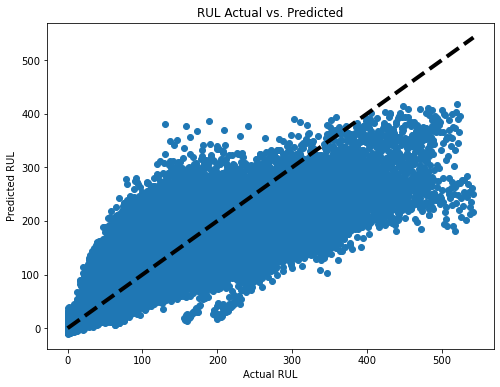

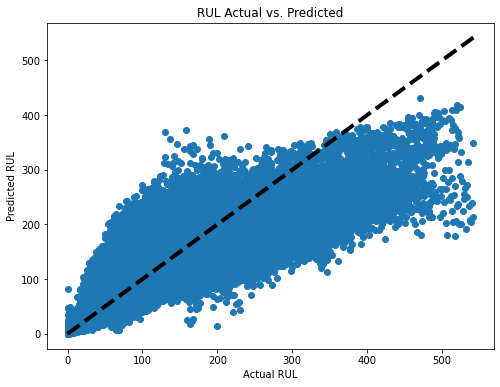

In [17]:
import lightgbm as lgb

regressor = lgb.LGBMRegressor(**best_params)
regressor.fit(X_tr, y_tr, eval_set=(X_te, y_te), verbose=0)
lgb_y_pred = regressor.predict(X)

xgb_model = xgb.XGBRegressor(**xgb_best)
xgb_model.fit(X_tr, y_tr, eval_set = [(X_te, y_te)],  early_stopping_rounds=10)
xgb_y_pred = xgb_model.predict(X)

def draw_rul_graph(y_act, y_pred):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(y, y_pred)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Actual RUL')
    ax.set_ylabel('Predicted RUL')
    ax.set_title('RUL Actual vs. Predicted')
    plt.show()

draw_rul_graph(y, lgb_y_pred)
draw_rul_graph(y, xgb_y_pred)

In [ ]:
# K-Folds cross-validation stacking
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_stacking(X, y, model):
    counter = 0

    for tridx, teidx in cv.split(X):
        xtr_cv, xte_cv = X[tridx], X[teidx]
        ytr_cv, yte_cv = y[tridx], y[teidx]
        
        try:
            model.fit(xtr_cv, ytr_cv, eval_set=(xte_cv, yte_cv))
        except:
            model.fit(xtr_cv, ytr_cv, eval_set=[(xte_cv, yte_cv)])
            # I know this try-except architecture is not good. But don't care :P
        y_pred = model.predict(X)

        if counter == 0:
            summary = np.zeros(y_pred.shape[0])

        summary += y_pred
        counter += 1

    return summary

lgb_sum = cv_stacking(X, y, lgb.LGBMRegressor(**best_params))
xgb_sum = cv_stacking(X, y, xgb.XGBRegressor(**xgb_best))

summary = (lgb_sum + xgb_sum)/10

draw_rul_graph(y, summary)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=5.861166768736052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.861166768736052
[LightGBM] [Warning] lambda_l1 is set=9.209013255699873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.209013255699873
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[1]	valid_0's rmse: 79.9893
[2]	valid_0's rmse: 76.7093
[3]	valid_0's rmse: 73.6568
[4]	valid_0's rmse: 71.0826
[5]	valid_0's rmse: 69.1584
[6]	valid_0's rmse: 67.5446
[7]	valid_0's rmse: 65.6336
[8]	valid_0's rmse: 64.0811
[9]	valid_0's rmse: 62.7688
[10]	valid_0's rmse: 61.6519
[11]	valid_0's rmse: 60.4058
[12]	valid_0's rmse: 59.3725
[13]	valid_0's rmse: 58.6366
[14]	valid_0's rmse:

[278]	valid_0's rmse: 50.2385
[279]	valid_0's rmse: 50.2375
[280]	valid_0's rmse: 50.2359
[281]	valid_0's rmse: 50.2295
[282]	valid_0's rmse: 50.2284
[283]	valid_0's rmse: 50.2315
[284]	valid_0's rmse: 50.2257
[285]	valid_0's rmse: 50.2261
[286]	valid_0's rmse: 50.2257
[287]	valid_0's rmse: 50.2213
[288]	valid_0's rmse: 50.2175
[289]	valid_0's rmse: 50.216
[290]	valid_0's rmse: 50.2128
[291]	valid_0's rmse: 50.215
[292]	valid_0's rmse: 50.2135
[293]	valid_0's rmse: 50.2126
[294]	valid_0's rmse: 50.2126
[295]	valid_0's rmse: 50.2091
[296]	valid_0's rmse: 50.2096
[297]	valid_0's rmse: 50.2092
[298]	valid_0's rmse: 50.2086
[299]	valid_0's rmse: 50.2087
[300]	valid_0's rmse: 50.2074
[301]	valid_0's rmse: 50.2054
[302]	valid_0's rmse: 50.2058
[303]	valid_0's rmse: 50.2044
[304]	valid_0's rmse: 50.2037
[305]	valid_0's rmse: 50.2024
[306]	valid_0's rmse: 50.2025
[307]	valid_0's rmse: 50.1999
[308]	valid_0's rmse: 50.1968
[309]	valid_0's rmse: 50.197
[310]	valid_0's rmse: 50.1965
[311]	valid_0

[575]	valid_0's rmse: 50.0861
[576]	valid_0's rmse: 50.0866
[577]	valid_0's rmse: 50.0878
[578]	valid_0's rmse: 50.0866
[579]	valid_0's rmse: 50.0848
[580]	valid_0's rmse: 50.0838
[581]	valid_0's rmse: 50.0824
[582]	valid_0's rmse: 50.0827
[583]	valid_0's rmse: 50.0809
[584]	valid_0's rmse: 50.0817
[585]	valid_0's rmse: 50.0829
[586]	valid_0's rmse: 50.0822
[587]	valid_0's rmse: 50.0825
[588]	valid_0's rmse: 50.0835
[589]	valid_0's rmse: 50.0828
[590]	valid_0's rmse: 50.0821
[591]	valid_0's rmse: 50.082
[592]	valid_0's rmse: 50.081
[593]	valid_0's rmse: 50.082
[594]	valid_0's rmse: 50.0821
[595]	valid_0's rmse: 50.0817
[596]	valid_0's rmse: 50.0808
[597]	valid_0's rmse: 50.0822
[598]	valid_0's rmse: 50.0829
[599]	valid_0's rmse: 50.0857
[600]	valid_0's rmse: 50.0865
[601]	valid_0's rmse: 50.0861
[602]	valid_0's rmse: 50.0841
[603]	valid_0's rmse: 50.0835
[604]	valid_0's rmse: 50.085
[605]	valid_0's rmse: 50.0839
[606]	valid_0's rmse: 50.0836
[607]	valid_0's rmse: 50.0845
[608]	valid_0'

[850]	valid_0's rmse: 50.092
[851]	valid_0's rmse: 50.0925
[852]	valid_0's rmse: 50.0918
[853]	valid_0's rmse: 50.0908
[854]	valid_0's rmse: 50.0914
[855]	valid_0's rmse: 50.0934
[856]	valid_0's rmse: 50.0947
[857]	valid_0's rmse: 50.0937
[858]	valid_0's rmse: 50.0969
[859]	valid_0's rmse: 50.0965
[860]	valid_0's rmse: 50.0972
[861]	valid_0's rmse: 50.0989
[862]	valid_0's rmse: 50.1005
[863]	valid_0's rmse: 50.0998
[864]	valid_0's rmse: 50.1011
[865]	valid_0's rmse: 50.1023
[866]	valid_0's rmse: 50.1023
[867]	valid_0's rmse: 50.1032
[868]	valid_0's rmse: 50.1023
[869]	valid_0's rmse: 50.1021
[870]	valid_0's rmse: 50.1026
[871]	valid_0's rmse: 50.1036
[872]	valid_0's rmse: 50.1056
[873]	valid_0's rmse: 50.1066
[874]	valid_0's rmse: 50.1055
[875]	valid_0's rmse: 50.1076
[876]	valid_0's rmse: 50.1076
[877]	valid_0's rmse: 50.1081
[878]	valid_0's rmse: 50.1071
[879]	valid_0's rmse: 50.1069
[880]	valid_0's rmse: 50.1065
[881]	valid_0's rmse: 50.1067
[882]	valid_0's rmse: 50.1065
[883]	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=5.861166768736052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.861166768736052
[LightGBM] [Warning] lambda_l1 is set=9.209013255699873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.209013255699873
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[1]	valid_0's rmse: 80.3418
[2]	valid_0's rmse: 77.057
[3]	valid_0's rmse: 73.9947
[4]	valid_0's rmse: 71.4186
[5]	valid_0's rmse: 69.4525
[6]	valid_0's rmse: 67.7776
[7]	valid_0's rmse: 65.9375
[8]	valid_0's rmse: 64.4329
[9]	valid_0's rmse: 63.118
[10]	valid_0's rmse: 61.9618
[11]	valid_0's rmse: 60.6664
[12]	valid_0's rmse: 59.552
[13]	valid_0's rmse: 58.7647
[14]	valid_0's rmse: 57

[263]	valid_0's rmse: 49.961
[264]	valid_0's rmse: 49.9618
[265]	valid_0's rmse: 49.9598
[266]	valid_0's rmse: 49.9579
[267]	valid_0's rmse: 49.9562
[268]	valid_0's rmse: 49.9557
[269]	valid_0's rmse: 49.9537
[270]	valid_0's rmse: 49.9515
[271]	valid_0's rmse: 49.9503
[272]	valid_0's rmse: 49.9456
[273]	valid_0's rmse: 49.9473
[274]	valid_0's rmse: 49.9473
[275]	valid_0's rmse: 49.948
[276]	valid_0's rmse: 49.9456
[277]	valid_0's rmse: 49.945
[278]	valid_0's rmse: 49.9445
[279]	valid_0's rmse: 49.9432
[280]	valid_0's rmse: 49.942
[281]	valid_0's rmse: 49.9412
[282]	valid_0's rmse: 49.9399
[283]	valid_0's rmse: 49.9386
[284]	valid_0's rmse: 49.9378
[285]	valid_0's rmse: 49.9373
[286]	valid_0's rmse: 49.9364
[287]	valid_0's rmse: 49.931
[288]	valid_0's rmse: 49.9298
[289]	valid_0's rmse: 49.9289
[290]	valid_0's rmse: 49.9284
[291]	valid_0's rmse: 49.9268
[292]	valid_0's rmse: 49.9241
[293]	valid_0's rmse: 49.9251
[294]	valid_0's rmse: 49.926
[295]	valid_0's rmse: 49.9254
[296]	valid_0's 

[560]	valid_0's rmse: 49.8302
[561]	valid_0's rmse: 49.83
[562]	valid_0's rmse: 49.8295
[563]	valid_0's rmse: 49.8303
[564]	valid_0's rmse: 49.8312
[565]	valid_0's rmse: 49.8315
[566]	valid_0's rmse: 49.8325
[567]	valid_0's rmse: 49.8343
[568]	valid_0's rmse: 49.8339
[569]	valid_0's rmse: 49.8335
[570]	valid_0's rmse: 49.8342
[571]	valid_0's rmse: 49.8339
[572]	valid_0's rmse: 49.8339
[573]	valid_0's rmse: 49.8344
[574]	valid_0's rmse: 49.8347
[575]	valid_0's rmse: 49.8348
[576]	valid_0's rmse: 49.8341
[577]	valid_0's rmse: 49.8348
[578]	valid_0's rmse: 49.8356
[579]	valid_0's rmse: 49.8351
[580]	valid_0's rmse: 49.835
[581]	valid_0's rmse: 49.8348
[582]	valid_0's rmse: 49.8351
[583]	valid_0's rmse: 49.8342
[584]	valid_0's rmse: 49.8339
[585]	valid_0's rmse: 49.8341
[586]	valid_0's rmse: 49.8355
[587]	valid_0's rmse: 49.8346
[588]	valid_0's rmse: 49.836
[589]	valid_0's rmse: 49.8354
[590]	valid_0's rmse: 49.836
[591]	valid_0's rmse: 49.8378
[592]	valid_0's rmse: 49.8364
[593]	valid_0's

[866]	valid_0's rmse: 49.819
[867]	valid_0's rmse: 49.8217
[868]	valid_0's rmse: 49.8222
[869]	valid_0's rmse: 49.8242
[870]	valid_0's rmse: 49.8251
[871]	valid_0's rmse: 49.8246
[872]	valid_0's rmse: 49.8244
[873]	valid_0's rmse: 49.8243
[874]	valid_0's rmse: 49.8253
[875]	valid_0's rmse: 49.8267
[876]	valid_0's rmse: 49.827
[877]	valid_0's rmse: 49.827
[878]	valid_0's rmse: 49.8248
[879]	valid_0's rmse: 49.8249
[880]	valid_0's rmse: 49.824
[881]	valid_0's rmse: 49.8256
[882]	valid_0's rmse: 49.8248
[883]	valid_0's rmse: 49.8232
[884]	valid_0's rmse: 49.8223
[885]	valid_0's rmse: 49.8229
[886]	valid_0's rmse: 49.8243
[887]	valid_0's rmse: 49.8235
[888]	valid_0's rmse: 49.8228
[889]	valid_0's rmse: 49.8245
[890]	valid_0's rmse: 49.8245
[891]	valid_0's rmse: 49.8268
[892]	valid_0's rmse: 49.8252
[893]	valid_0's rmse: 49.8253
[894]	valid_0's rmse: 49.8252
[895]	valid_0's rmse: 49.8249
[896]	valid_0's rmse: 49.8239
[897]	valid_0's rmse: 49.8249
[898]	valid_0's rmse: 49.8239
[899]	valid_0'

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=5.861166768736052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.861166768736052
[LightGBM] [Warning] lambda_l1 is set=9.209013255699873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.209013255699873
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[1]	valid_0's rmse: 79.4067
[2]	valid_0's rmse: 76.1627
[3]	valid_0's rmse: 73.0947
[4]	valid_0's rmse: 70.5382
[5]	valid_0's rmse: 68.5655
[6]	valid_0's rmse: 66.9273
[7]	valid_0's rmse: 65.0242
[8]	valid_0's rmse: 63.5092
[9]	valid_0's rmse: 62.1792
[10]	valid_0's rmse: 61.0015
[11]	valid_0's rmse: 59.7652
[12]	valid_0's rmse: 58.693
[13]	valid_0's rmse: 57.9469
[14]	valid_0's rmse: 

[266]	valid_0's rmse: 49.596
[267]	valid_0's rmse: 49.5944
[268]	valid_0's rmse: 49.5963
[269]	valid_0's rmse: 49.5951
[270]	valid_0's rmse: 49.5944
[271]	valid_0's rmse: 49.5926
[272]	valid_0's rmse: 49.5914
[273]	valid_0's rmse: 49.5874
[274]	valid_0's rmse: 49.5881
[275]	valid_0's rmse: 49.5878
[276]	valid_0's rmse: 49.5877
[277]	valid_0's rmse: 49.5844
[278]	valid_0's rmse: 49.586
[279]	valid_0's rmse: 49.5855
[280]	valid_0's rmse: 49.5844
[281]	valid_0's rmse: 49.578
[282]	valid_0's rmse: 49.5778
[283]	valid_0's rmse: 49.5763
[284]	valid_0's rmse: 49.5724
[285]	valid_0's rmse: 49.5716
[286]	valid_0's rmse: 49.5691
[287]	valid_0's rmse: 49.5667
[288]	valid_0's rmse: 49.5646
[289]	valid_0's rmse: 49.5651
[290]	valid_0's rmse: 49.5569
[291]	valid_0's rmse: 49.557
[292]	valid_0's rmse: 49.5562
[293]	valid_0's rmse: 49.5573
[294]	valid_0's rmse: 49.5547
[295]	valid_0's rmse: 49.5559
[296]	valid_0's rmse: 49.5546
[297]	valid_0's rmse: 49.5534
[298]	valid_0's rmse: 49.5524
[299]	valid_0'

[558]	valid_0's rmse: 49.4317
[559]	valid_0's rmse: 49.4309
[560]	valid_0's rmse: 49.4323
[561]	valid_0's rmse: 49.4316
[562]	valid_0's rmse: 49.4329
[563]	valid_0's rmse: 49.4337
[564]	valid_0's rmse: 49.4351
[565]	valid_0's rmse: 49.434
[566]	valid_0's rmse: 49.4343
[567]	valid_0's rmse: 49.4339
[568]	valid_0's rmse: 49.4307
[569]	valid_0's rmse: 49.4297
[570]	valid_0's rmse: 49.4286
[571]	valid_0's rmse: 49.4248
[572]	valid_0's rmse: 49.4246
[573]	valid_0's rmse: 49.4222
[574]	valid_0's rmse: 49.4202
[575]	valid_0's rmse: 49.4229
[576]	valid_0's rmse: 49.4213
[577]	valid_0's rmse: 49.4223
[578]	valid_0's rmse: 49.4222
[579]	valid_0's rmse: 49.4215
[580]	valid_0's rmse: 49.4226
[581]	valid_0's rmse: 49.4227
[582]	valid_0's rmse: 49.4238
[583]	valid_0's rmse: 49.4202
[584]	valid_0's rmse: 49.4216
[585]	valid_0's rmse: 49.422
[586]	valid_0's rmse: 49.4208
[587]	valid_0's rmse: 49.4208
[588]	valid_0's rmse: 49.421
[589]	valid_0's rmse: 49.4211
[590]	valid_0's rmse: 49.4212
[591]	valid_0

[861]	valid_0's rmse: 49.4294
[862]	valid_0's rmse: 49.4312
[863]	valid_0's rmse: 49.4317
[864]	valid_0's rmse: 49.4329
[865]	valid_0's rmse: 49.432
[866]	valid_0's rmse: 49.4318
[867]	valid_0's rmse: 49.4317
[868]	valid_0's rmse: 49.4312
[869]	valid_0's rmse: 49.4306
[870]	valid_0's rmse: 49.43
[871]	valid_0's rmse: 49.4299
[872]	valid_0's rmse: 49.4304
[873]	valid_0's rmse: 49.4281
[874]	valid_0's rmse: 49.4281
[875]	valid_0's rmse: 49.4282
[876]	valid_0's rmse: 49.4272
[877]	valid_0's rmse: 49.4238
[878]	valid_0's rmse: 49.4222
[879]	valid_0's rmse: 49.4218
[880]	valid_0's rmse: 49.4232
[881]	valid_0's rmse: 49.4241
[882]	valid_0's rmse: 49.4264
[883]	valid_0's rmse: 49.4254
[884]	valid_0's rmse: 49.4231
[885]	valid_0's rmse: 49.4236
[886]	valid_0's rmse: 49.423
[887]	valid_0's rmse: 49.4241
[888]	valid_0's rmse: 49.4244
[889]	valid_0's rmse: 49.424
[890]	valid_0's rmse: 49.4246
[891]	valid_0's rmse: 49.425
[892]	valid_0's rmse: 49.4258
[893]	valid_0's rmse: 49.4274
[894]	valid_0's 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=5.861166768736052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.861166768736052
[LightGBM] [Warning] lambda_l1 is set=9.209013255699873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.209013255699873
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[1]	valid_0's rmse: 80.3612
[2]	valid_0's rmse: 77.1053
[3]	valid_0's rmse: 74.0565
[4]	valid_0's rmse: 71.6767
[5]	valid_0's rmse: 69.7772
[6]	valid_0's rmse: 68.0922
[7]	valid_0's rmse: 66.2695
[8]	valid_0's rmse: 64.6999
[9]	valid_0's rmse: 63.3829
[10]	valid_0's rmse: 62.3133
[11]	valid_0's rmse: 61.0645
[12]	valid_0's rmse: 59.9755
[13]	valid_0's rmse: 59.1808
[14]	valid_0's rmse:

[273]	valid_0's rmse: 50.5452
[274]	valid_0's rmse: 50.5451
[275]	valid_0's rmse: 50.5442
[276]	valid_0's rmse: 50.5444
[277]	valid_0's rmse: 50.5447
[278]	valid_0's rmse: 50.5442
[279]	valid_0's rmse: 50.5443
[280]	valid_0's rmse: 50.5442
[281]	valid_0's rmse: 50.5399
[282]	valid_0's rmse: 50.5385
[283]	valid_0's rmse: 50.5366
[284]	valid_0's rmse: 50.5223
[285]	valid_0's rmse: 50.5199
[286]	valid_0's rmse: 50.5189
[287]	valid_0's rmse: 50.5183
[288]	valid_0's rmse: 50.5174
[289]	valid_0's rmse: 50.5159
[290]	valid_0's rmse: 50.5152
[291]	valid_0's rmse: 50.5125
[292]	valid_0's rmse: 50.5099
[293]	valid_0's rmse: 50.5093
[294]	valid_0's rmse: 50.5085
[295]	valid_0's rmse: 50.507
[296]	valid_0's rmse: 50.506
[297]	valid_0's rmse: 50.5048
[298]	valid_0's rmse: 50.5036
[299]	valid_0's rmse: 50.4924
[300]	valid_0's rmse: 50.4888
[301]	valid_0's rmse: 50.4882
[302]	valid_0's rmse: 50.4867
[303]	valid_0's rmse: 50.4866
[304]	valid_0's rmse: 50.4875
[305]	valid_0's rmse: 50.4885
[306]	valid_

[577]	valid_0's rmse: 50.3157
[578]	valid_0's rmse: 50.3149
[579]	valid_0's rmse: 50.3148
[580]	valid_0's rmse: 50.3139
[581]	valid_0's rmse: 50.3128
[582]	valid_0's rmse: 50.3152
[583]	valid_0's rmse: 50.3152
[584]	valid_0's rmse: 50.3165
[585]	valid_0's rmse: 50.3163
[586]	valid_0's rmse: 50.3164
[587]	valid_0's rmse: 50.3152
[588]	valid_0's rmse: 50.3162
[589]	valid_0's rmse: 50.3153
[590]	valid_0's rmse: 50.3108
[591]	valid_0's rmse: 50.3111
[592]	valid_0's rmse: 50.3103
[593]	valid_0's rmse: 50.3087
[594]	valid_0's rmse: 50.3089
[595]	valid_0's rmse: 50.3081
[596]	valid_0's rmse: 50.3078
[597]	valid_0's rmse: 50.3086
[598]	valid_0's rmse: 50.3084
[599]	valid_0's rmse: 50.3097
[600]	valid_0's rmse: 50.3106
[601]	valid_0's rmse: 50.3102
[602]	valid_0's rmse: 50.3112
[603]	valid_0's rmse: 50.3063
[604]	valid_0's rmse: 50.3065
[605]	valid_0's rmse: 50.3054
[606]	valid_0's rmse: 50.3054
[607]	valid_0's rmse: 50.3059
[608]	valid_0's rmse: 50.3051
[609]	valid_0's rmse: 50.3043
[610]	vali

[888]	valid_0's rmse: 50.2917
[889]	valid_0's rmse: 50.2929
[890]	valid_0's rmse: 50.2902
[891]	valid_0's rmse: 50.2909
[892]	valid_0's rmse: 50.2915
[893]	valid_0's rmse: 50.2922
[894]	valid_0's rmse: 50.2934
[895]	valid_0's rmse: 50.2943
[896]	valid_0's rmse: 50.2951
[897]	valid_0's rmse: 50.2949
[898]	valid_0's rmse: 50.2961
[899]	valid_0's rmse: 50.2981
[900]	valid_0's rmse: 50.2984
[901]	valid_0's rmse: 50.2982
[902]	valid_0's rmse: 50.2966
[903]	valid_0's rmse: 50.2956
[904]	valid_0's rmse: 50.2967
[905]	valid_0's rmse: 50.2965
[906]	valid_0's rmse: 50.2967
[907]	valid_0's rmse: 50.2976
[908]	valid_0's rmse: 50.2972
[909]	valid_0's rmse: 50.2968
[910]	valid_0's rmse: 50.2953
[911]	valid_0's rmse: 50.2962
[912]	valid_0's rmse: 50.2971
[913]	valid_0's rmse: 50.2986
[914]	valid_0's rmse: 50.2983
[915]	valid_0's rmse: 50.299
[916]	valid_0's rmse: 50.3002
[917]	valid_0's rmse: 50.3
[918]	valid_0's rmse: 50.3
[919]	valid_0's rmse: 50.299
[920]	valid_0's rmse: 50.2986
[921]	valid_0's rm

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=5.861166768736052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.861166768736052
[LightGBM] [Warning] lambda_l1 is set=9.209013255699873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.209013255699873
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[1]	valid_0's rmse: 80.2194
[2]	valid_0's rmse: 76.9758
[3]	valid_0's rmse: 73.9165
[4]	valid_0's rmse: 71.3605
[5]	valid_0's rmse: 69.4091
[6]	valid_0's rmse: 67.6896
[7]	valid_0's rmse: 65.8621
[8]	valid_0's rmse: 64.3067
[9]	valid_0's rmse: 62.9674
[10]	valid_0's rmse: 61.8068
[11]	valid_0's rmse: 60.5711
[12]	valid_0's rmse: 59.4933
[13]	valid_0's rmse: 58.722
[14]	valid_0's rmse: 

[260]	valid_0's rmse: 50.1447
[261]	valid_0's rmse: 50.1419
[262]	valid_0's rmse: 50.1392
[263]	valid_0's rmse: 50.1375
[264]	valid_0's rmse: 50.1341
[265]	valid_0's rmse: 50.1346
[266]	valid_0's rmse: 50.1346
[267]	valid_0's rmse: 50.1349
[268]	valid_0's rmse: 50.1336
[269]	valid_0's rmse: 50.1308
[270]	valid_0's rmse: 50.1309
[271]	valid_0's rmse: 50.1292
[272]	valid_0's rmse: 50.1255
[273]	valid_0's rmse: 50.1236
[274]	valid_0's rmse: 50.1209
[275]	valid_0's rmse: 50.1199
[276]	valid_0's rmse: 50.1159
[277]	valid_0's rmse: 50.1082
[278]	valid_0's rmse: 50.1068
[279]	valid_0's rmse: 50.1062
[280]	valid_0's rmse: 50.1081
[281]	valid_0's rmse: 50.1014
[282]	valid_0's rmse: 50.0997
[283]	valid_0's rmse: 50.0978
[284]	valid_0's rmse: 50.0972
[285]	valid_0's rmse: 50.0983
[286]	valid_0's rmse: 50.0964
[287]	valid_0's rmse: 50.0851
[288]	valid_0's rmse: 50.0842
[289]	valid_0's rmse: 50.0831
[290]	valid_0's rmse: 50.0803
[291]	valid_0's rmse: 50.0805
[292]	valid_0's rmse: 50.0814
[293]	vali

[566]	valid_0's rmse: 49.8765
[567]	valid_0's rmse: 49.8754
[568]	valid_0's rmse: 49.8754
[569]	valid_0's rmse: 49.8751
[570]	valid_0's rmse: 49.8743
[571]	valid_0's rmse: 49.8746
[572]	valid_0's rmse: 49.8751
[573]	valid_0's rmse: 49.875
[574]	valid_0's rmse: 49.8754
[575]	valid_0's rmse: 49.8754
[576]	valid_0's rmse: 49.8756
[577]	valid_0's rmse: 49.8744
[578]	valid_0's rmse: 49.8746
[579]	valid_0's rmse: 49.8768
[580]	valid_0's rmse: 49.8768
[581]	valid_0's rmse: 49.8777
[582]	valid_0's rmse: 49.8779
[583]	valid_0's rmse: 49.8783
[584]	valid_0's rmse: 49.8779
[585]	valid_0's rmse: 49.8788
[586]	valid_0's rmse: 49.8805
[587]	valid_0's rmse: 49.88
[588]	valid_0's rmse: 49.8793
[589]	valid_0's rmse: 49.88
[590]	valid_0's rmse: 49.8801
[591]	valid_0's rmse: 49.8815
[592]	valid_0's rmse: 49.8821
[593]	valid_0's rmse: 49.8812
[594]	valid_0's rmse: 49.8816
[595]	valid_0's rmse: 49.8794
[596]	valid_0's rmse: 49.8798
[597]	valid_0's rmse: 49.8798
[598]	valid_0's rmse: 49.8788
[599]	valid_0's

[894]	valid_0's rmse: 49.8337
[895]	valid_0's rmse: 49.8333
[896]	valid_0's rmse: 49.8328
[897]	valid_0's rmse: 49.8331
[898]	valid_0's rmse: 49.833
[899]	valid_0's rmse: 49.8332
[900]	valid_0's rmse: 49.8349
[901]	valid_0's rmse: 49.8347
[902]	valid_0's rmse: 49.8338
[903]	valid_0's rmse: 49.8338
[904]	valid_0's rmse: 49.8359
[905]	valid_0's rmse: 49.8372
[906]	valid_0's rmse: 49.8377
[907]	valid_0's rmse: 49.8377
[908]	valid_0's rmse: 49.8368
[909]	valid_0's rmse: 49.8379
[910]	valid_0's rmse: 49.8371
[911]	valid_0's rmse: 49.8357
[912]	valid_0's rmse: 49.8343
[913]	valid_0's rmse: 49.8329
[914]	valid_0's rmse: 49.8336
[915]	valid_0's rmse: 49.8335
[916]	valid_0's rmse: 49.8344
[917]	valid_0's rmse: 49.836
[918]	valid_0's rmse: 49.8364
[919]	valid_0's rmse: 49.8361
[920]	valid_0's rmse: 49.8358
[921]	valid_0's rmse: 49.8381
[922]	valid_0's rmse: 49.8362
[923]	valid_0's rmse: 49.8357
[924]	valid_0's rmse: 49.8336
[925]	valid_0's rmse: 49.8345
[926]	valid_0's rmse: 49.836
[927]	valid_0

[144]	validation_0-rmse:52.71809
[145]	validation_0-rmse:52.63791
[146]	validation_0-rmse:52.56749
[147]	validation_0-rmse:52.48778
[148]	validation_0-rmse:52.41543
[149]	validation_0-rmse:52.34710
[150]	validation_0-rmse:52.28901
[151]	validation_0-rmse:52.22842
[152]	validation_0-rmse:52.16433
[153]	validation_0-rmse:52.10535
[154]	validation_0-rmse:52.04081
[155]	validation_0-rmse:51.98059
[156]	validation_0-rmse:51.92674
[157]	validation_0-rmse:51.87178
[158]	validation_0-rmse:51.81444
[159]	validation_0-rmse:51.76542
[160]	validation_0-rmse:51.71039
[161]	validation_0-rmse:51.66373
[162]	validation_0-rmse:51.61998
[163]	validation_0-rmse:51.57692
[164]	validation_0-rmse:51.53426
[165]	validation_0-rmse:51.48633
[166]	validation_0-rmse:51.44481
[167]	validation_0-rmse:51.40771
[168]	validation_0-rmse:51.36865
[169]	validation_0-rmse:51.33259
[170]	validation_0-rmse:51.29711
[171]	validation_0-rmse:51.26157
[172]	validation_0-rmse:51.22836
[173]	validation_0-rmse:51.19525
[174]	vali

[393]	validation_0-rmse:49.80074
[394]	validation_0-rmse:49.80029
[395]	validation_0-rmse:49.79907
[396]	validation_0-rmse:49.80000
[397]	validation_0-rmse:49.80113
[398]	validation_0-rmse:49.80129
[399]	validation_0-rmse:49.79706
[400]	validation_0-rmse:49.79706
[401]	validation_0-rmse:49.79476
[402]	validation_0-rmse:49.79353
[403]	validation_0-rmse:49.79455
[404]	validation_0-rmse:49.79487
[405]	validation_0-rmse:49.79369
[406]	validation_0-rmse:49.79421
[407]	validation_0-rmse:49.79384
[408]	validation_0-rmse:49.79367
[409]	validation_0-rmse:49.79384
[410]	validation_0-rmse:49.79379
[411]	validation_0-rmse:49.79390
[412]	validation_0-rmse:49.79377
[413]	validation_0-rmse:49.79342
[414]	validation_0-rmse:49.79338
[415]	validation_0-rmse:49.79203
[416]	validation_0-rmse:49.79228
[417]	validation_0-rmse:49.79216
[418]	validation_0-rmse:49.79216
[419]	validation_0-rmse:49.79236
[420]	validation_0-rmse:49.79221
[421]	validation_0-rmse:49.79254
[422]	validation_0-rmse:49.79199
[423]	vali

[76]	validation_0-rmse:67.56531
[77]	validation_0-rmse:67.12945
[78]	validation_0-rmse:66.69879
[79]	validation_0-rmse:66.28642
[80]	validation_0-rmse:65.87449
[81]	validation_0-rmse:65.47530
[82]	validation_0-rmse:65.09281
[83]	validation_0-rmse:64.71680
[84]	validation_0-rmse:64.35551
[85]	validation_0-rmse:63.99496
[86]	validation_0-rmse:63.64827
[87]	validation_0-rmse:63.30906
[88]	validation_0-rmse:62.97482
[89]	validation_0-rmse:62.65581
[90]	validation_0-rmse:62.33106
[91]	validation_0-rmse:62.02156
[92]	validation_0-rmse:61.72890
[93]	validation_0-rmse:61.43305
[94]	validation_0-rmse:61.13071
[95]	validation_0-rmse:60.85037
[96]	validation_0-rmse:60.56296
[97]	validation_0-rmse:60.28985
[98]	validation_0-rmse:60.02958
[99]	validation_0-rmse:59.77307
[100]	validation_0-rmse:59.52527
[101]	validation_0-rmse:59.27832
[102]	validation_0-rmse:59.03973
[103]	validation_0-rmse:58.80263
[104]	validation_0-rmse:58.56573
[105]	validation_0-rmse:58.35082
[106]	validation_0-rmse:58.13568
[

[325]	validation_0-rmse:49.71932
[326]	validation_0-rmse:49.71751
[327]	validation_0-rmse:49.71629
[328]	validation_0-rmse:49.71659
[329]	validation_0-rmse:49.71501
[330]	validation_0-rmse:49.71373
[331]	validation_0-rmse:49.71280
[332]	validation_0-rmse:49.71192
[333]	validation_0-rmse:49.70532
[334]	validation_0-rmse:49.70410
[335]	validation_0-rmse:49.69978
[336]	validation_0-rmse:49.69874
[337]	validation_0-rmse:49.69918
[338]	validation_0-rmse:49.69841
[339]	validation_0-rmse:49.69756
